# Polygon extraction
To extract the relevant data from the underlying image of Europe.  
![Europe 1918](input/europe_1918.png)
## 1. Remove non-map data
Such as : 
- The year indicator
- The population count
- The author's logo
- The countries' names
### 1.1. Manually remove logos and text

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import color
from shapely.geometry import box
from skimage import transform

import time

start_time = time.time()

def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

europe = color.rgba2rgb(plt.imread('input/europe_1918.png'))
display_img(europe, 'Europe 1918', True)

def disp_polygons(img, polygons, saveTo='') :
    todisp = img.copy()
    for polygon in polygons :
        (minx, miny, maxx, maxy) = np.array(polygon.bounds).astype(int)
        cv2.rectangle(todisp, (minx, miny), (maxx, maxy), (0, 0, int(np.max(todisp))), 2)
    display_img(todisp, '', True)
    if saveTo :
        plt.imsave(saveTo, todisp)
                      
def fill_polygons(img, polygons, fill_colors):
    res = img.copy()
    if np.ndim(fill_colors) == 1:
        fill_colors = [list(fill_colors)] * len(polygons)
    for i, polygon in enumerate(polygons) :
        [_, (xb, yb), _, (xa, ya), _] = [(int(x), int(y)) for (x, y) in polygon.exterior.coords]
        res[ya:yb, xa:xb] = fill_colors[i]
    return res
def display_colours(color_list) :
    size = len(color_list)
    plt.bar(range(size), [1]*size  , color=color_list)
    plt.show()

def get_surrounding_colors(img, polygon : box):
    offset = 1
    color_list = np.zeros((len(polygon.exterior.coords) , 3))
    x_left = int(np.array(polygon.exterior.coords)[:, 0].min()) - offset
    x_right = int(np.array(polygon.exterior.coords)[:, 0].max()) + offset
    y_top = int(np.array(polygon.exterior.coords)[:, 1].min()) - offset
    y_bottom = int(np.array(polygon.exterior.coords)[:, 1].max()) + offset
    corners =np.concatenate((
        img[y_top, x_left:x_right],
        img[y_bottom, x_left:x_right],
        img[y_top:y_bottom, x_left],
        img[y_top:y_bottom, x_right],
    ))
    res = np.median(corners, axis=0)
    return res
    
    
population_text_box = box(10, 230, 600, 1050)
logo_text_box = box(10, 10, 170, 150)
year_text_box_1 = box(800, 10, 1040, 150)
year_text_box_2 = box(1030, 30, 1070, 130)

to_remove = [population_text_box, logo_text_box, year_text_box_1, year_text_box_2]
surrounding_colors = [get_surrounding_colors(europe, box) for box in to_remove]
disp_polygons(europe, to_remove)

europe_cleaned = fill_polygons(europe, to_remove, surrounding_colors)
#europe_cleaned = transform.resize(europe_cleaned, (europe_cleaned.shape[0]/10, europe_cleaned.shape[1]/10))
plt.imsave('tmp/europe_cleaned.png', europe_cleaned)
display_img(europe_cleaned, 'Only map data are kept', True)

<Figure size 1440x1280 with 1 Axes>

<Figure size 1440x1280 with 1 Axes>

<Figure size 1440x1280 with 1 Axes>

## 2. Keep only the relevant colors

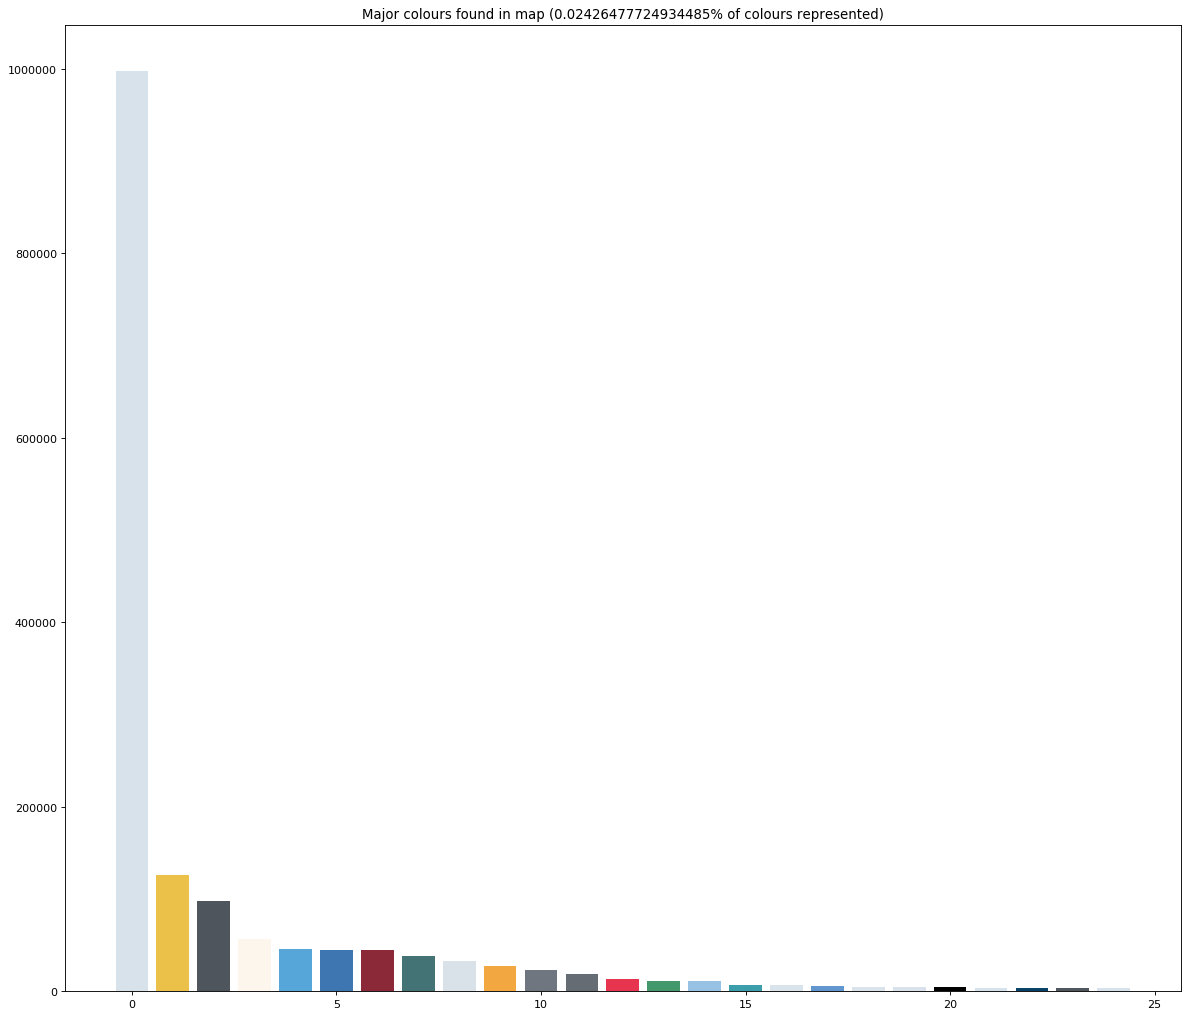

In [2]:
import pandas as pd
def extract_major_colors(img) :
    unique, counts = np.unique(img.reshape(int(img.size/3), 3), axis=0, return_counts=True)
    scores = list(zip(counts, unique))
    df = pd.DataFrame(scores, columns=['count', 'color']).sort_values(by=['count'], ascending=False)
    return df
def print_colors(extracted_colors):
    toplot = extracted_colors[:25]
    percentage = 100 * len(toplot)/len(extracted_colors)
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar(np.arange(len(toplot)) , toplot['count'].values , color=toplot['color'].values)
    plt.title('Major colours found in map ('+str(percentage)+'% of colours represented)')
    plt.show()
extracted =  extract_major_colors(europe_cleaned)
print_colors(extracted)

As displayed above, the image contains way too many colours. If we plan to extract countries based on colours, we'll first have to regroup these colours to make sense.  
This cane be done with the following clustering algorithm

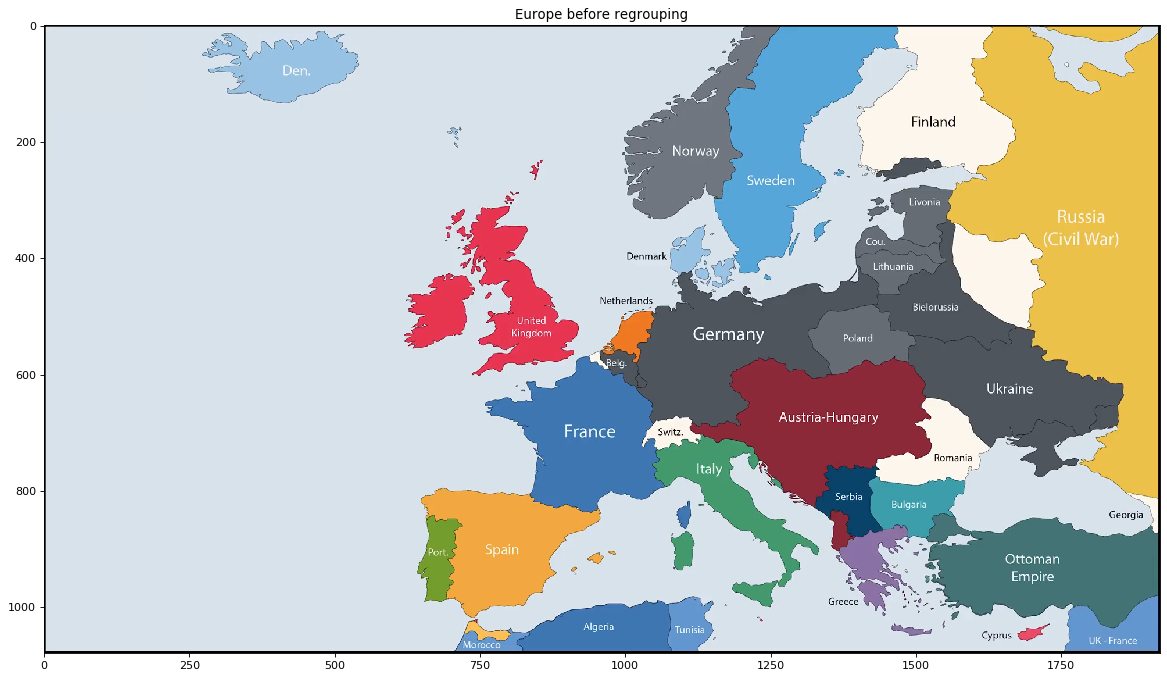

CPU times: user 8.93 s, sys: 111 ms, total: 9.04 s
Wall time: 8.09 s


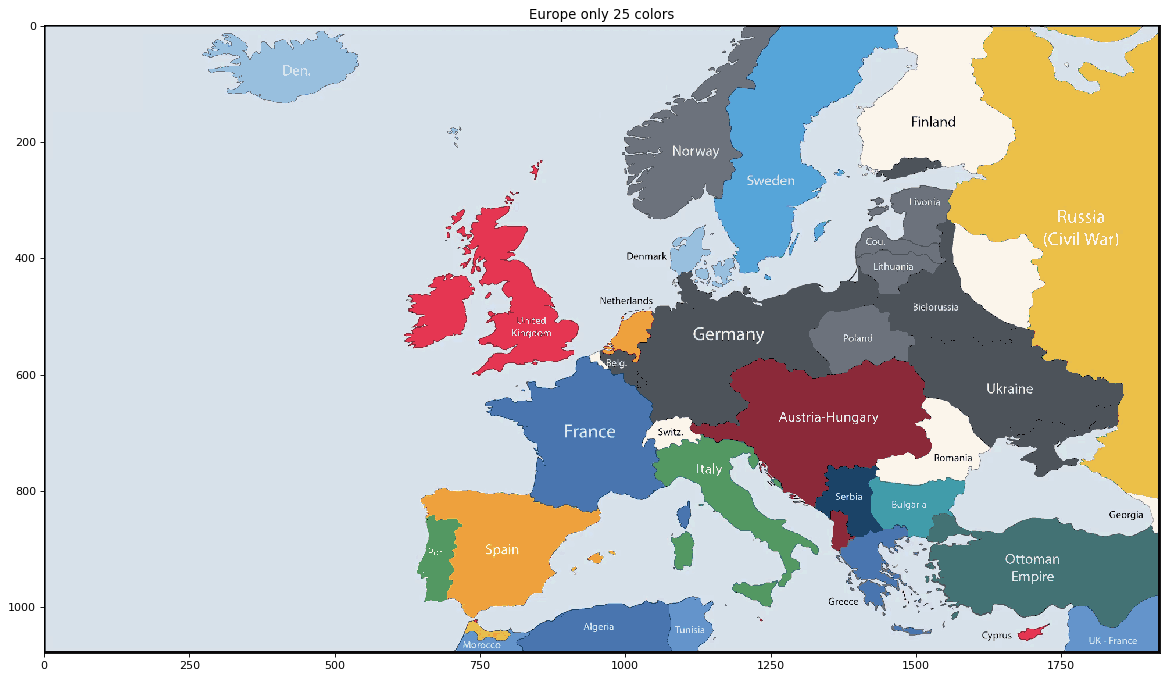

In [4]:
from sklearn.cluster import MiniBatchKMeans
import skimage.color

def regroup_colors(image, nb_colors) :
    (h, w) = image.shape[:2]
    # Lab is a colour representation (l, a , b). 
    # The kmeans computes an euclidian distance, lab is made so that if the perceived colour differ, the euclidian distance differs more than an rgb euclidian distance
    data = skimage.color.rgb2lab(image)
    
    #With location added, kmeans
    clt = MiniBatchKMeans(n_clusters = nb_colors, random_state = 0)
    labels = clt.fit_predict(data.reshape((h*w, 3)))
    res = clt.cluster_centers_[labels].reshape((h, w, 3))
    res = skimage.color.lab2rgb(res)
    return res

def exploreLAB(labimg):
    l = labimg[:, :, 0].flatten()
    a = labimg[:, :, 1].flatten()
    b = labimg[:, :, 2].flatten()
    plt.hist(l, bins=100)
    plt.hist(a, bins=100)
    plt.hist(b, bins=100)
    plt.show()
nb_color = 25
display_img(europe_cleaned, "Europe before regrouping", True)
#exploreLAB(color.rgb2lab(europe_cleaned))
%time clustered_europe_no_location = regroup_colors(europe_cleaned, nb_color)
display_img(clustered_europe_no_location, "Europe only "+str(nb_color)+" colors", True)

In [5]:
plt.imsave('tmp/clustered_europe.png', clustered_europe_no_location)

Now, the colour count has a meaning

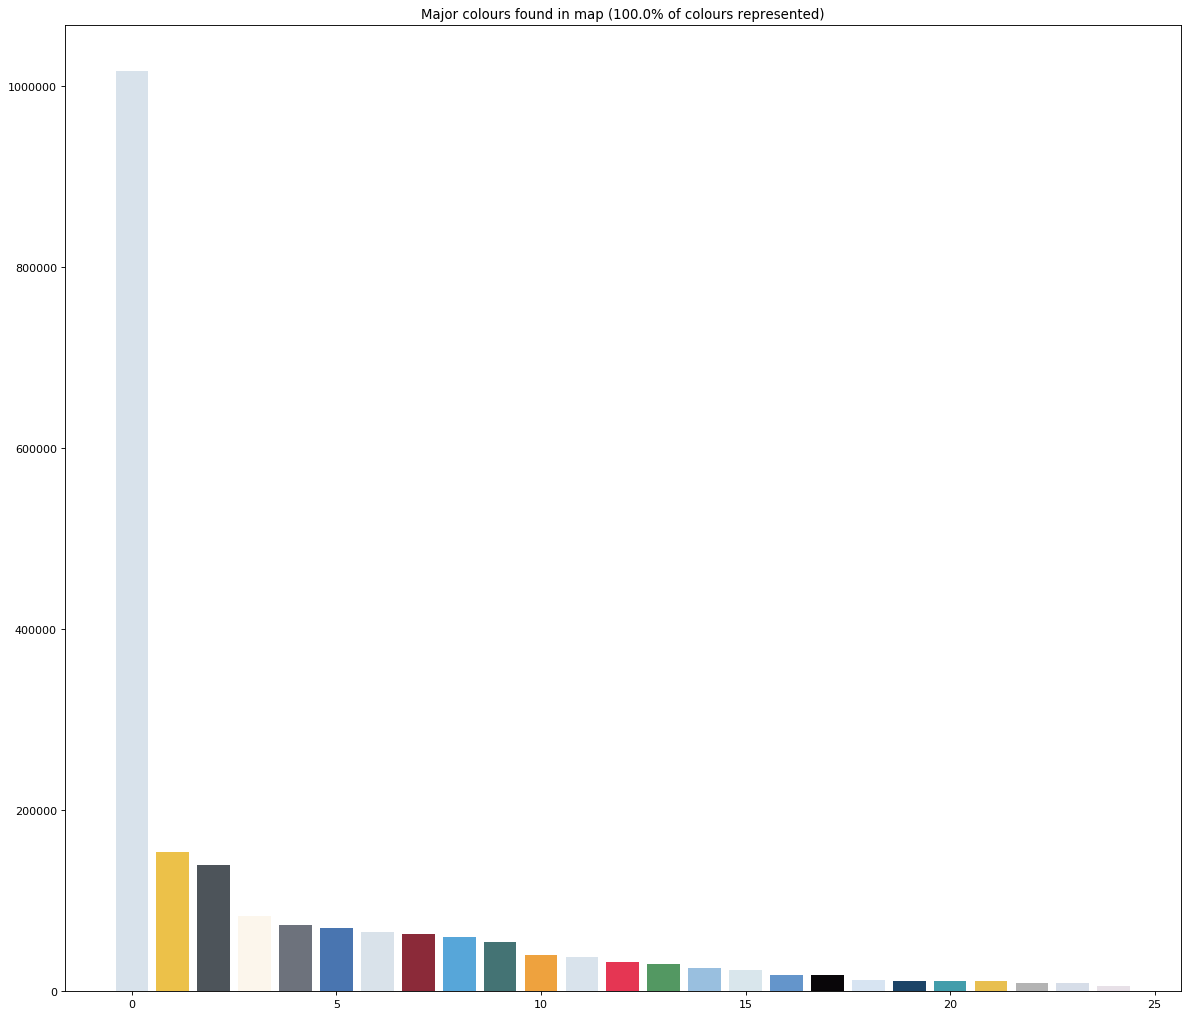

In [6]:
extracted_colors =  extract_major_colors(clustered_europe_no_location)
print_colors(extracted_colors)

## Remove the sea
As we're not interested in mapping the sea. Let's remove it from the extracted colors.  
Not only the sea color will be removed, but also all colors very close to the sea 

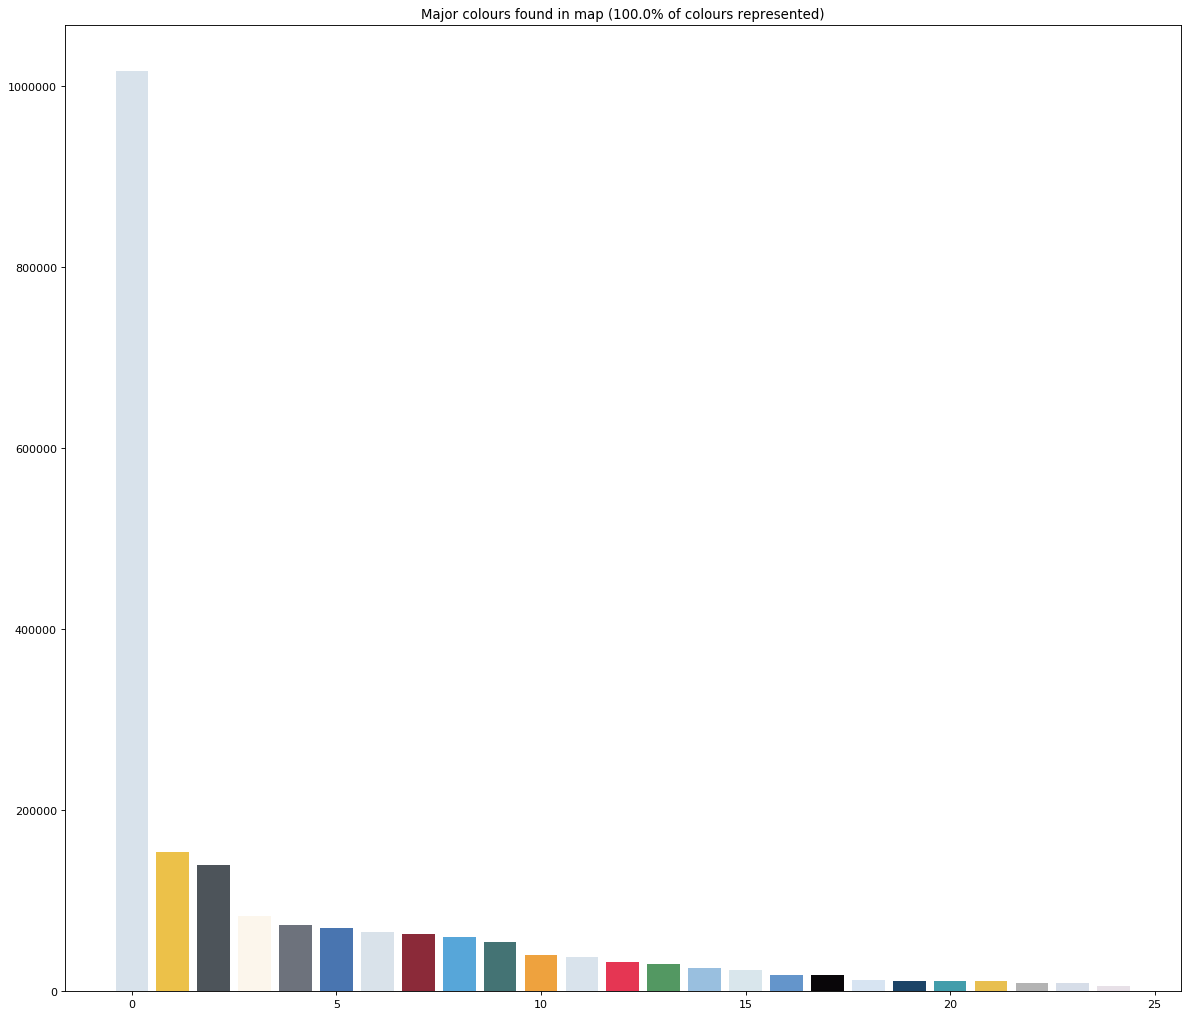

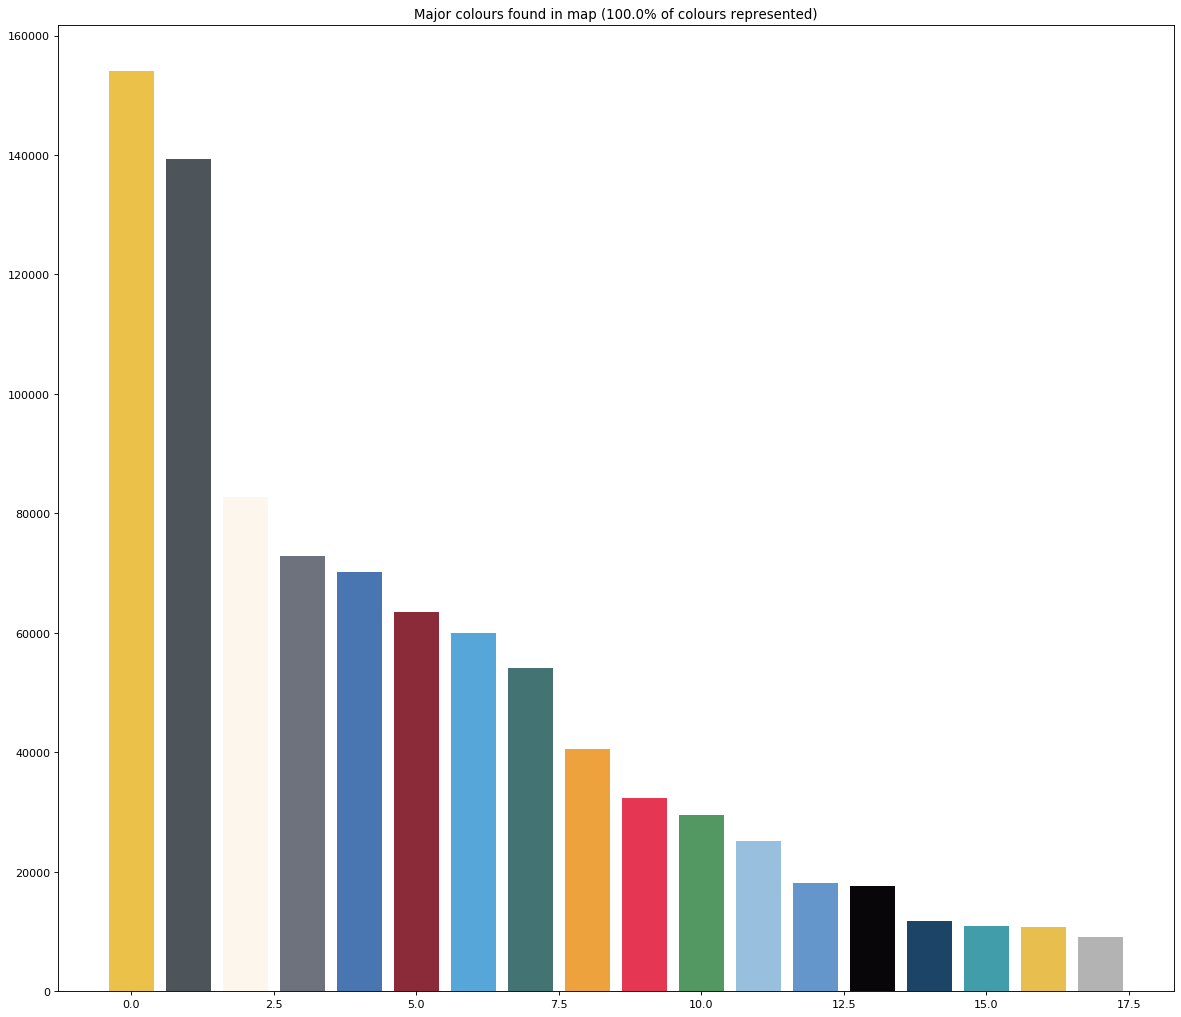

In [7]:
def colour_distance(rgb1, rgb2):
    [[lab1, lab2]] = skimage.color.rgb2lab([[rgb1, rgb2]])
    return np.linalg.norm(lab1 - lab2)

def remove_sea_colors(colordf):
    # Assuming the sea is the most represented color
    sea_color = colordf.iloc[0]['color']
    computed_distance = colordf.assign(distance_sea=colordf.color.apply(lambda color: colour_distance(sea_color, color)))
    return colordf[computed_distance.distance_sea > 10]


print_colors(extracted_colors)
land_colors = remove_sea_colors(extracted_colors)
print_colors(land_colors)

## Country extraction with a mask
Assuming colours exactly define the country, a mask can be applied to extract the country's borders


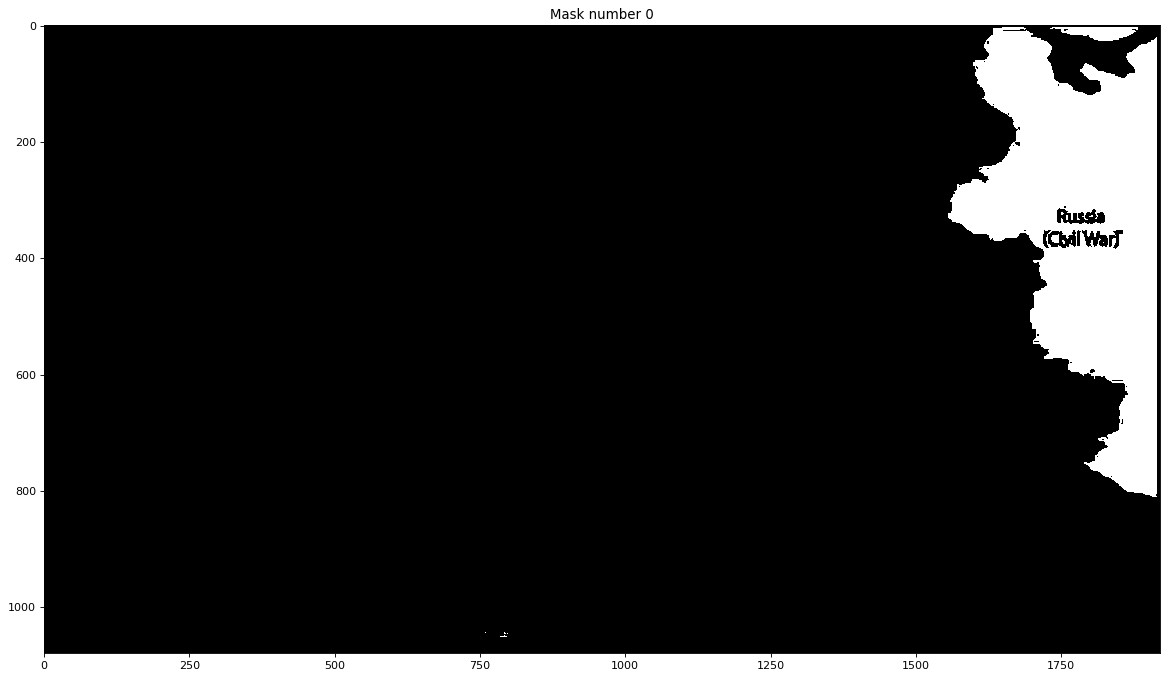

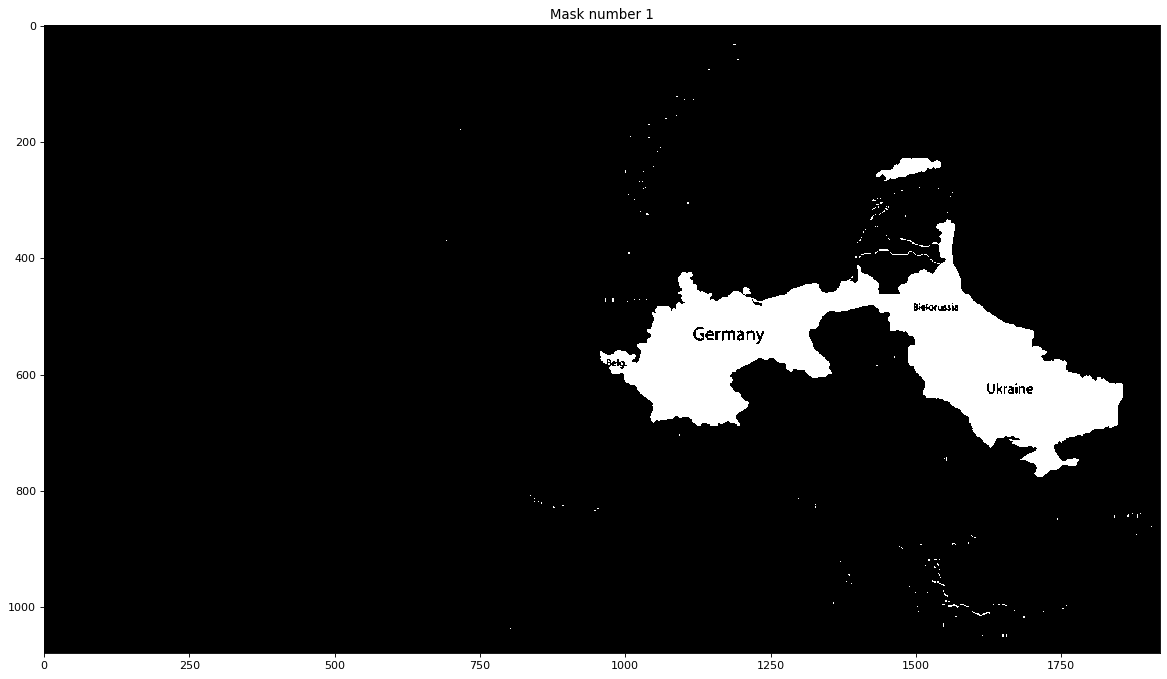

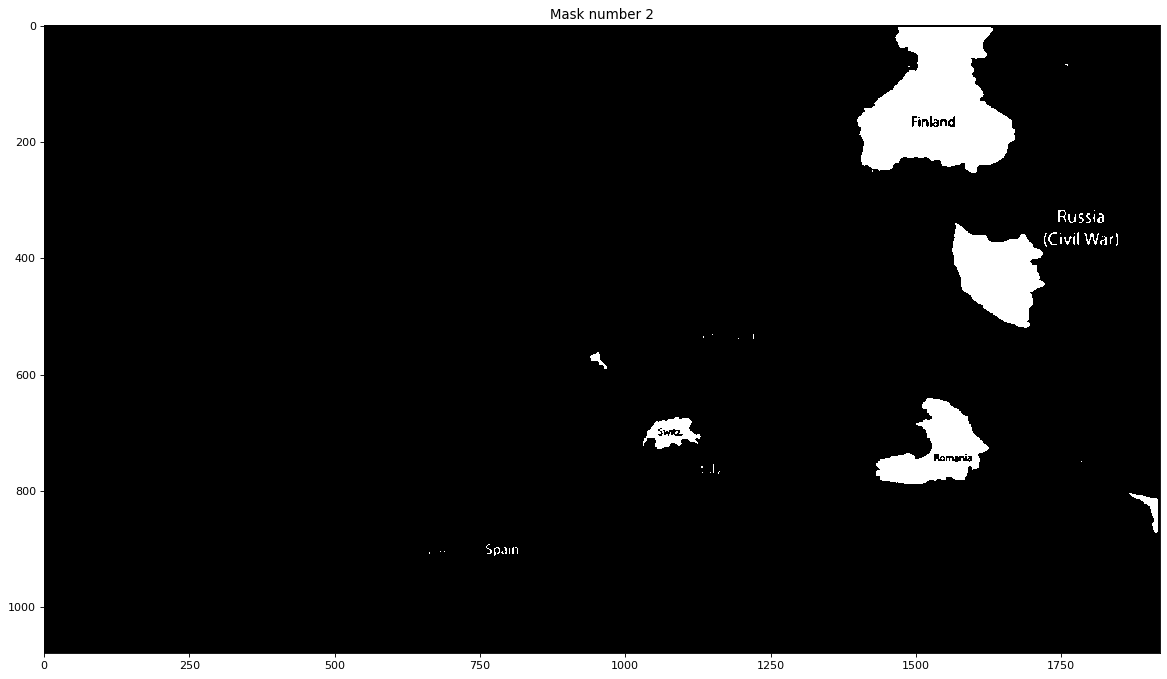

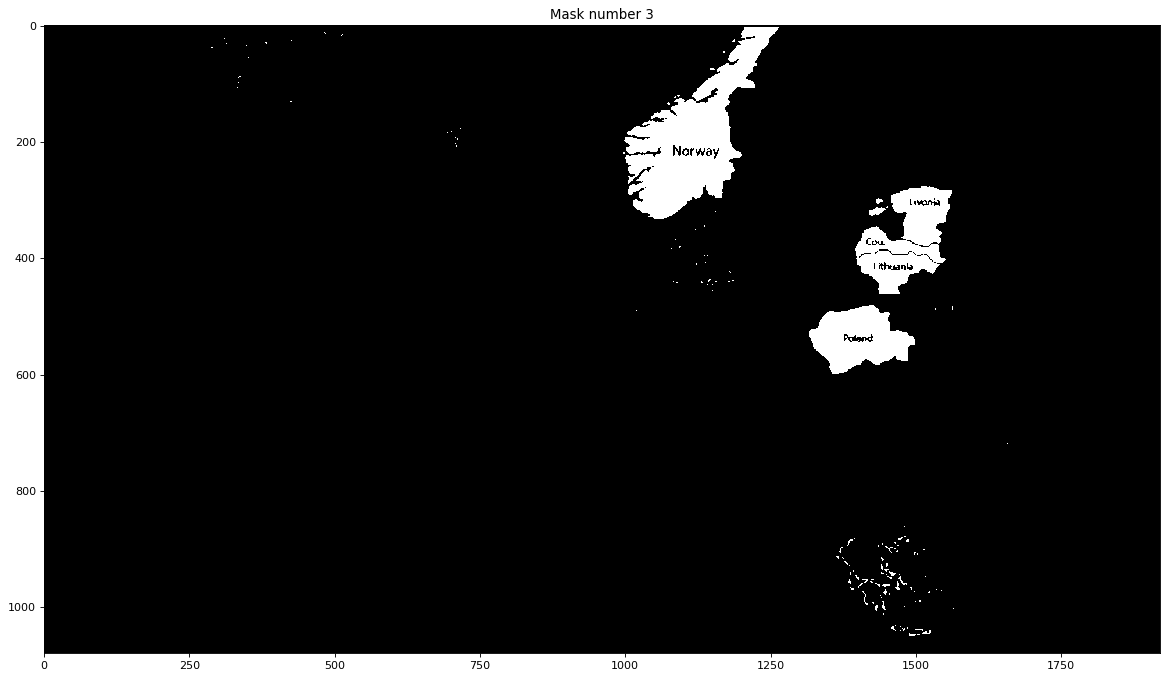

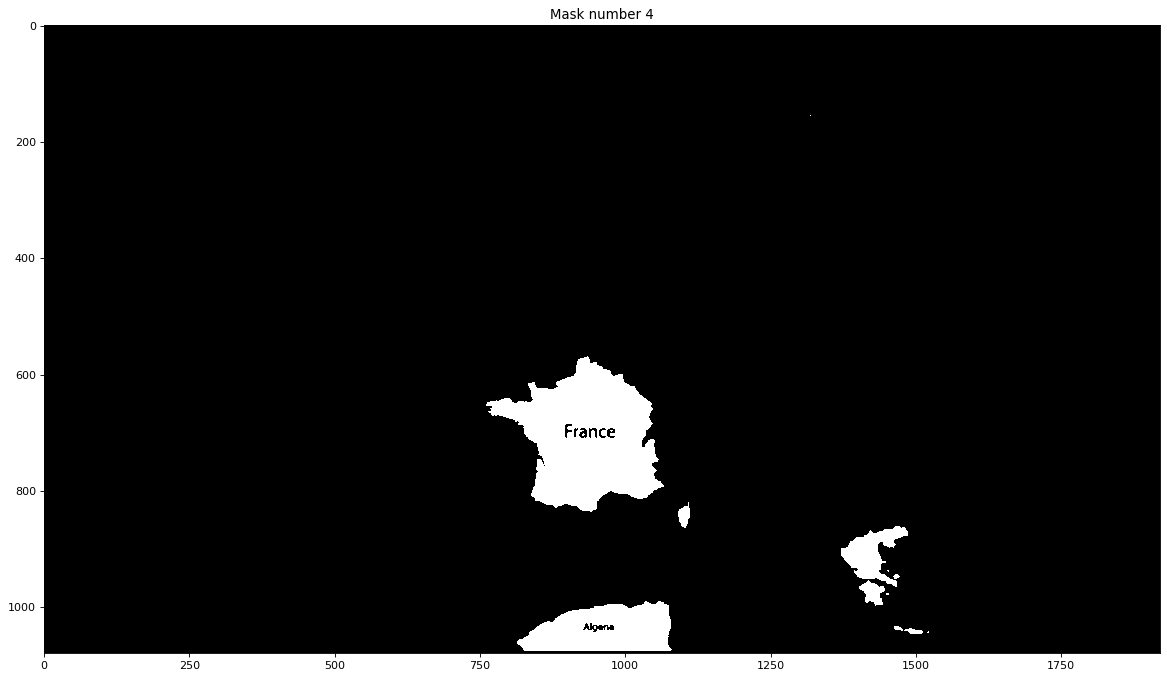

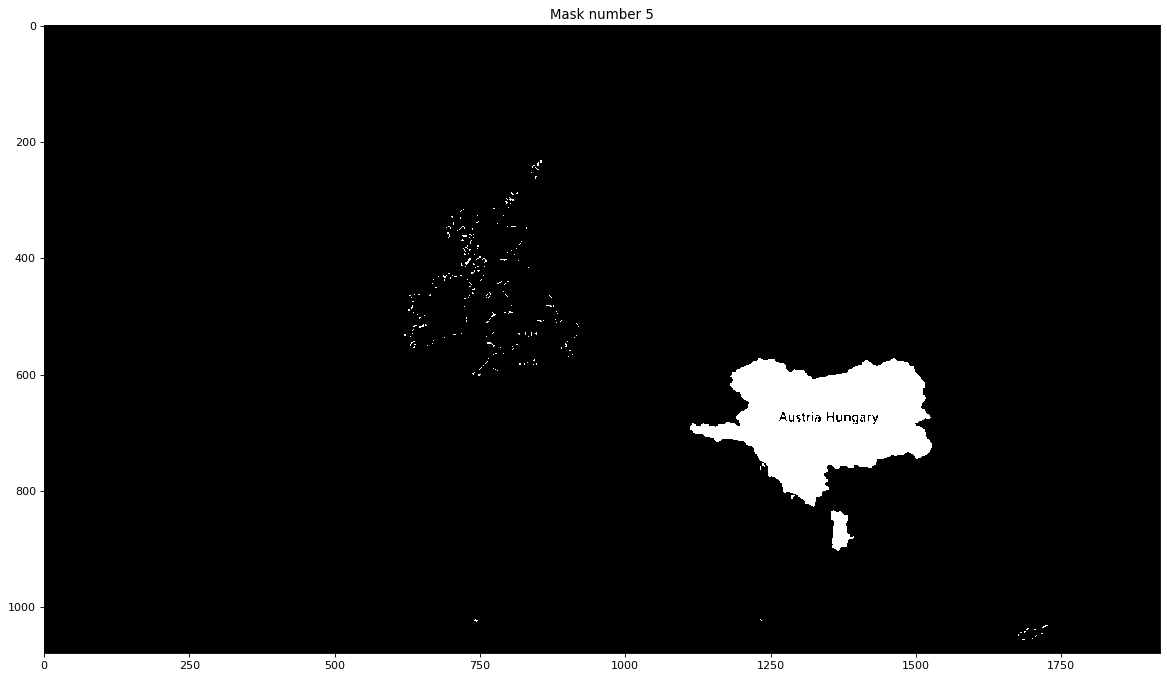

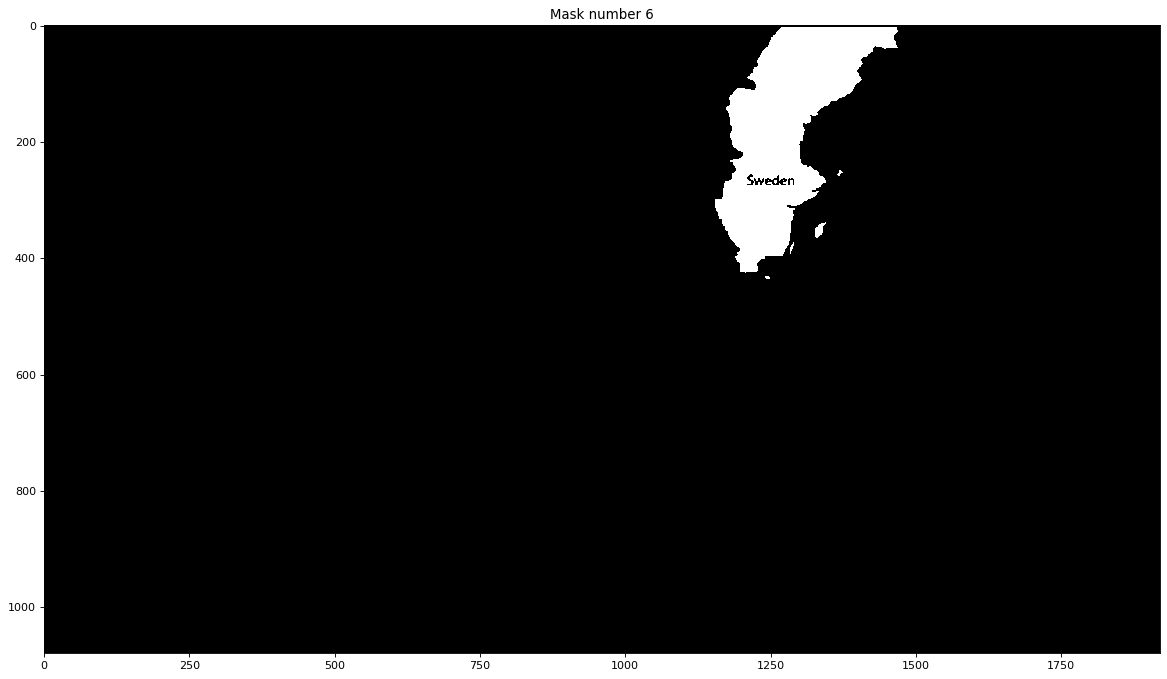

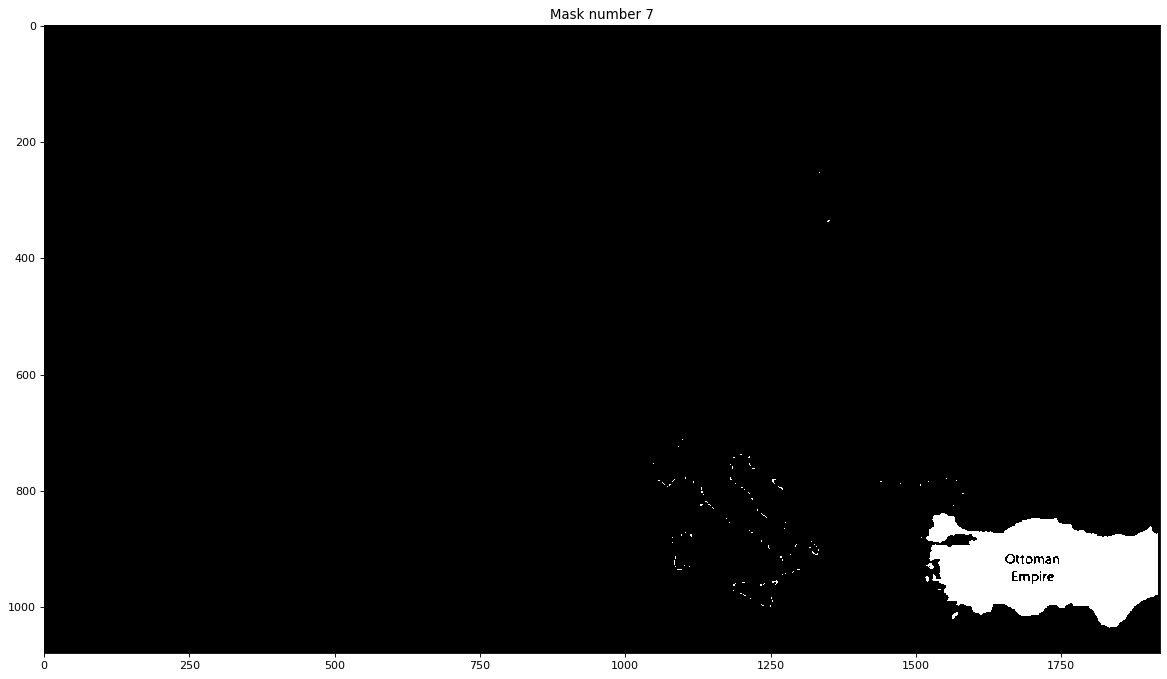

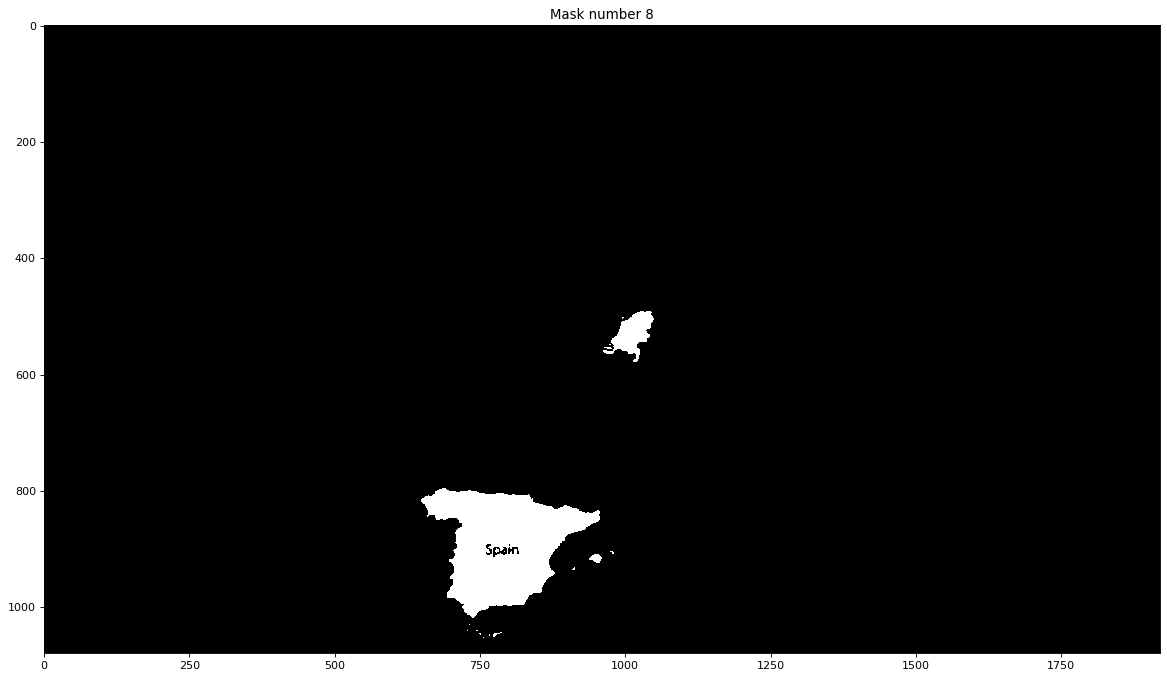

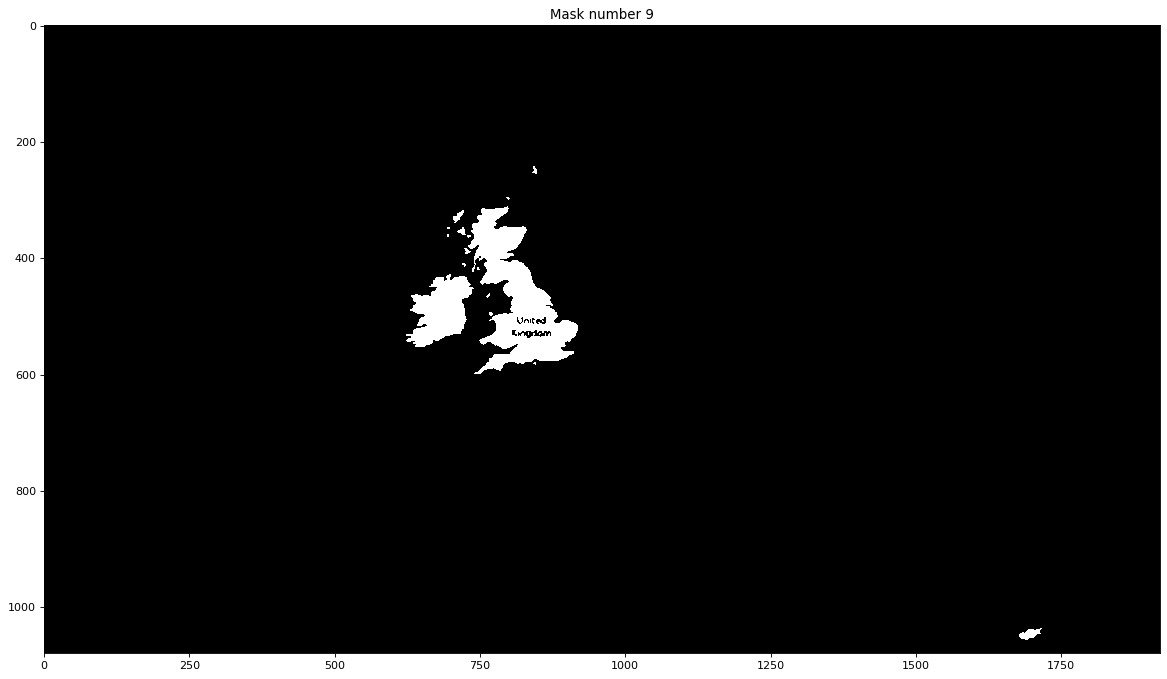

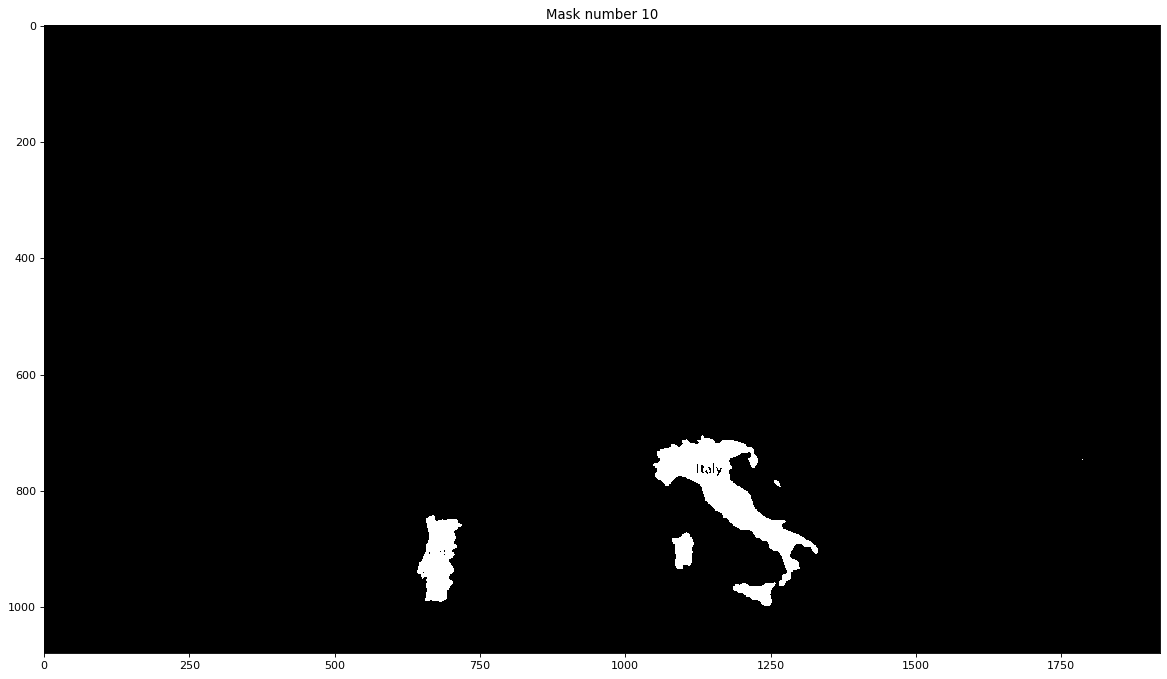

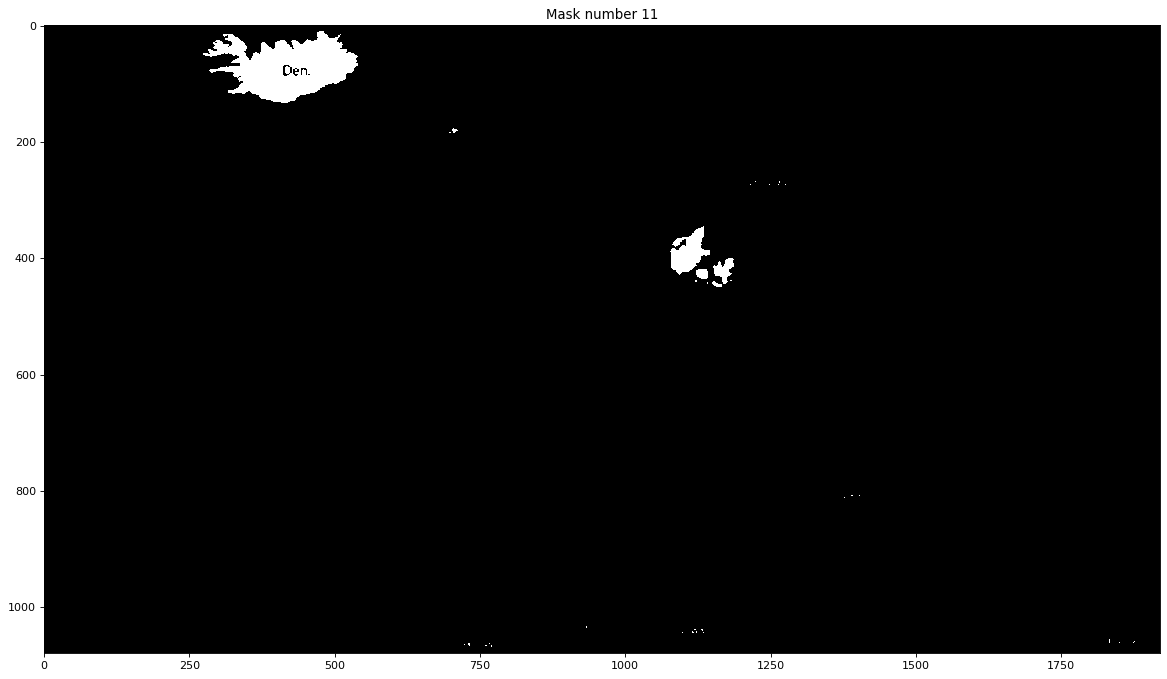

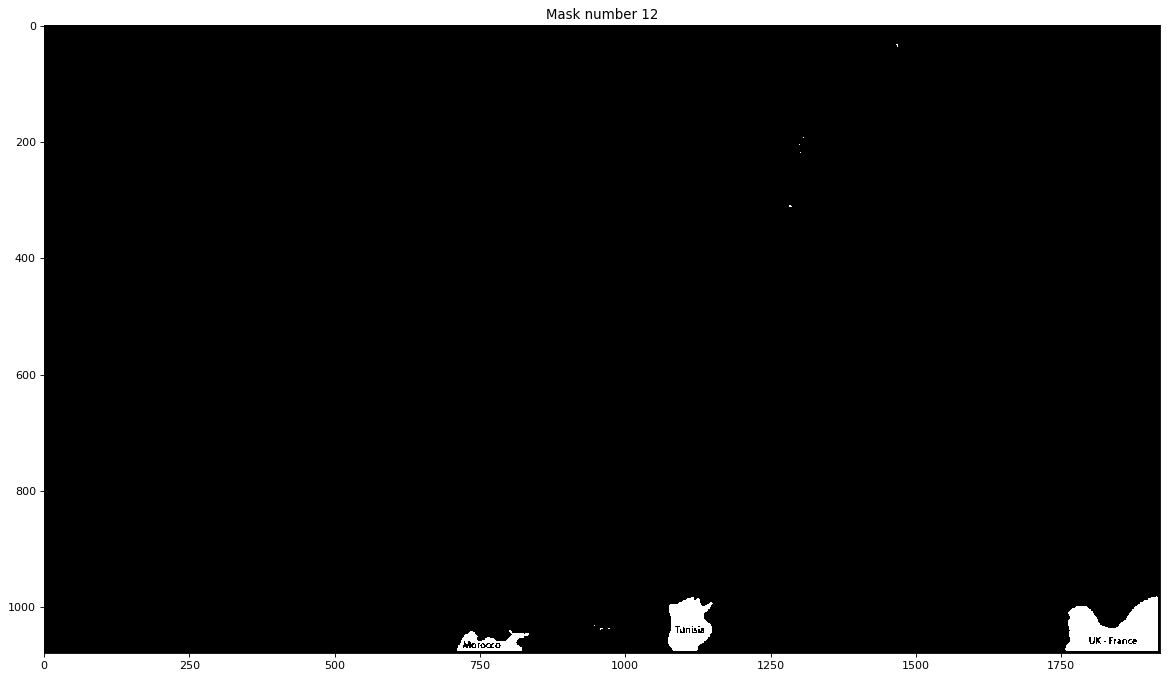

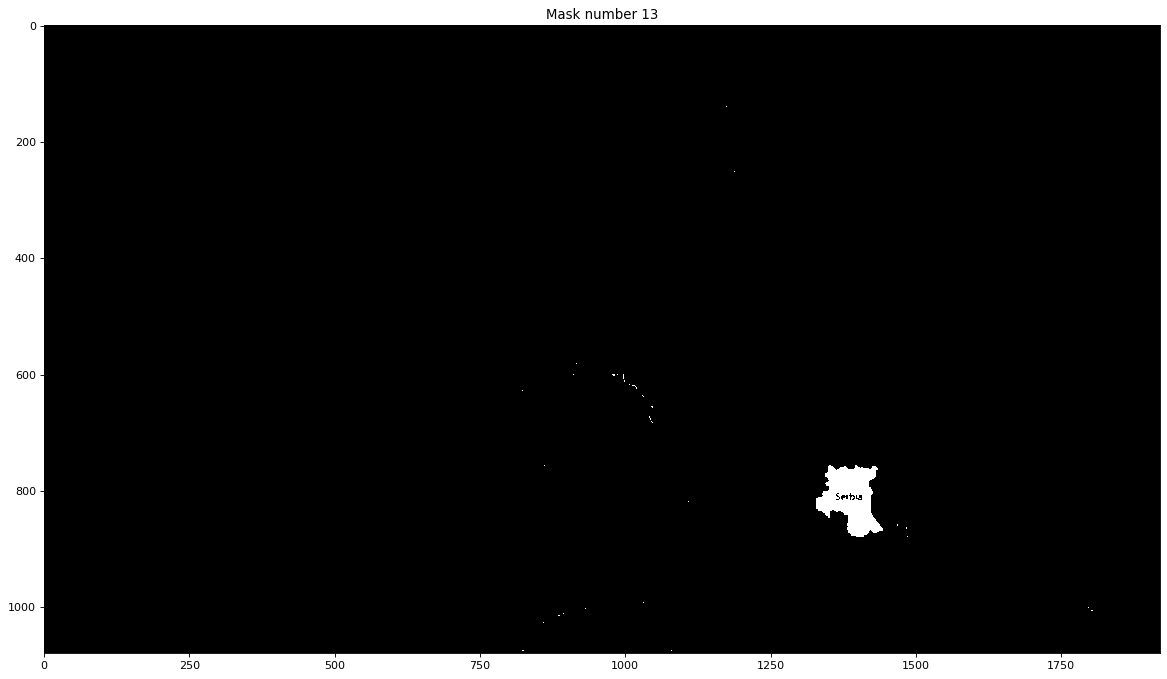

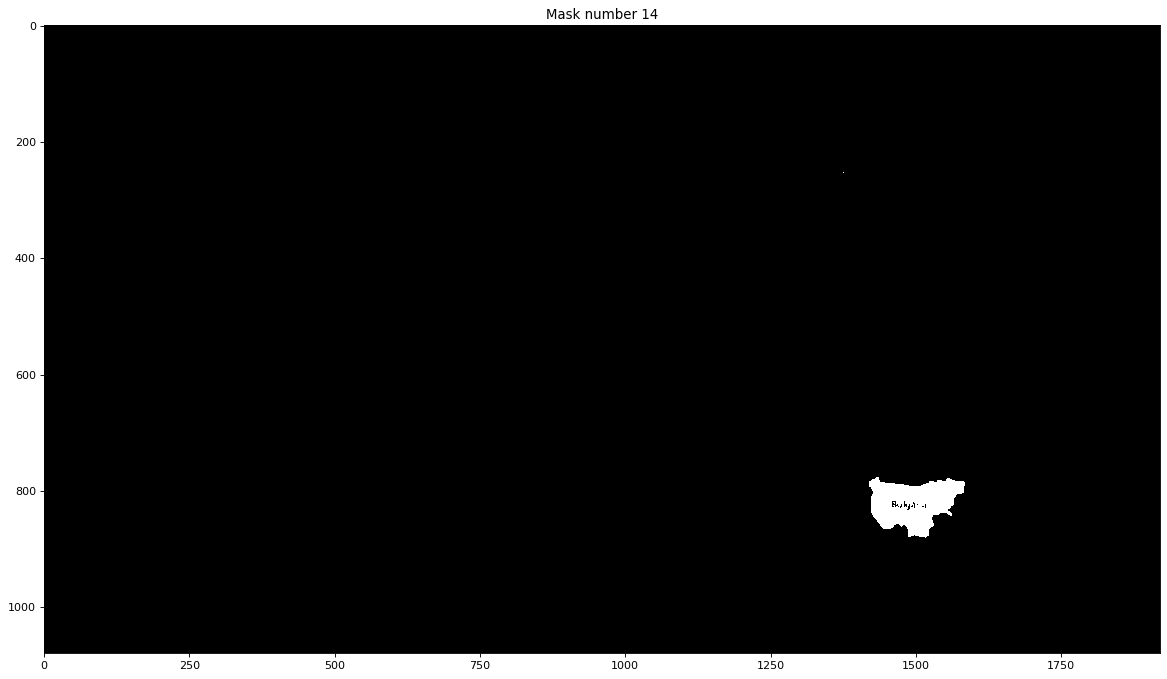

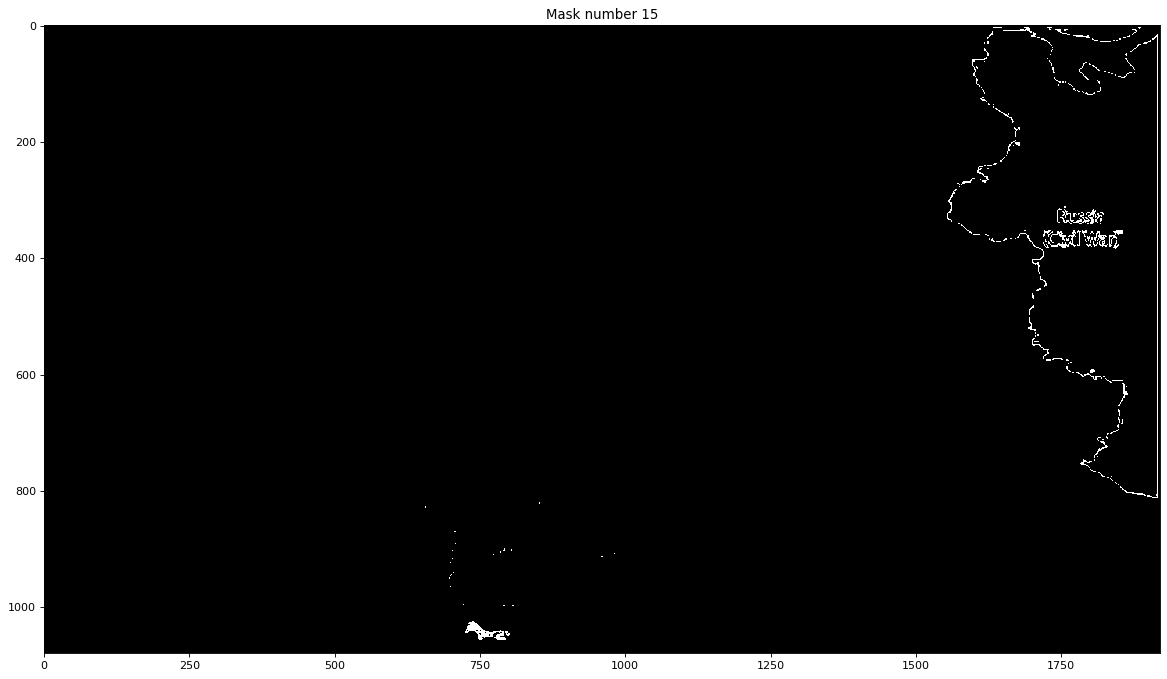

In [10]:
from skimage.filters.rank import median
import skimage.morphology

def get_masked(grayscale_img, grayscale_colors):
    return grayscale_img==grayscale_colors

def noise_reduction(img) : 
    return median(img, selem=np.ones((3, 3)))


#Passing europe and major colors to grayscale (only to make color comparison simpler)
grayscale_europe = color.rgb2gray(clustered_europe_no_location)


# Assuming the sea color is the most represented, filtering out every color that is close to the sea color

land_color_image = np.reshape(np.concatenate(land_colors.color.values), (1, len(land_colors), 3))
grayscale_major_colors = color.rgb2gray(land_color_image).flatten()

masks = []
for col in grayscale_major_colors:
    mask = get_masked(grayscale_europe,col)
    masks.append(mask)
masks = [noise_reduction(mask) for mask in masks]


# Some of the extracted major colors are border colors. The mask will just be scattered dots all around the map
# We don't want these masks and they can be filtered out with morphology. Performing an erosion will 
# remove the scattered dots. The mask will just be a black image, and will be removed
def get_eroded(img) :
    selem = skimage.morphology.disk(6)
    return skimage.morphology.erosion(img, selem)

def is_not_only_borders(bin_img):
    return np.count_nonzero(get_eroded(bin_img)) > 0


masks = [mask for mask in masks if is_not_only_borders(mask)]


for i, mask in enumerate(masks) :
    display_img(mask, 'Mask number '+str(i), True)

## To extract polygons from the mask
Scikit image provides a method to detect contours. A polygon can then be drawn from the extracted 
contours  
Here is how polygons will be extracted from a mask (let's consider the first one)

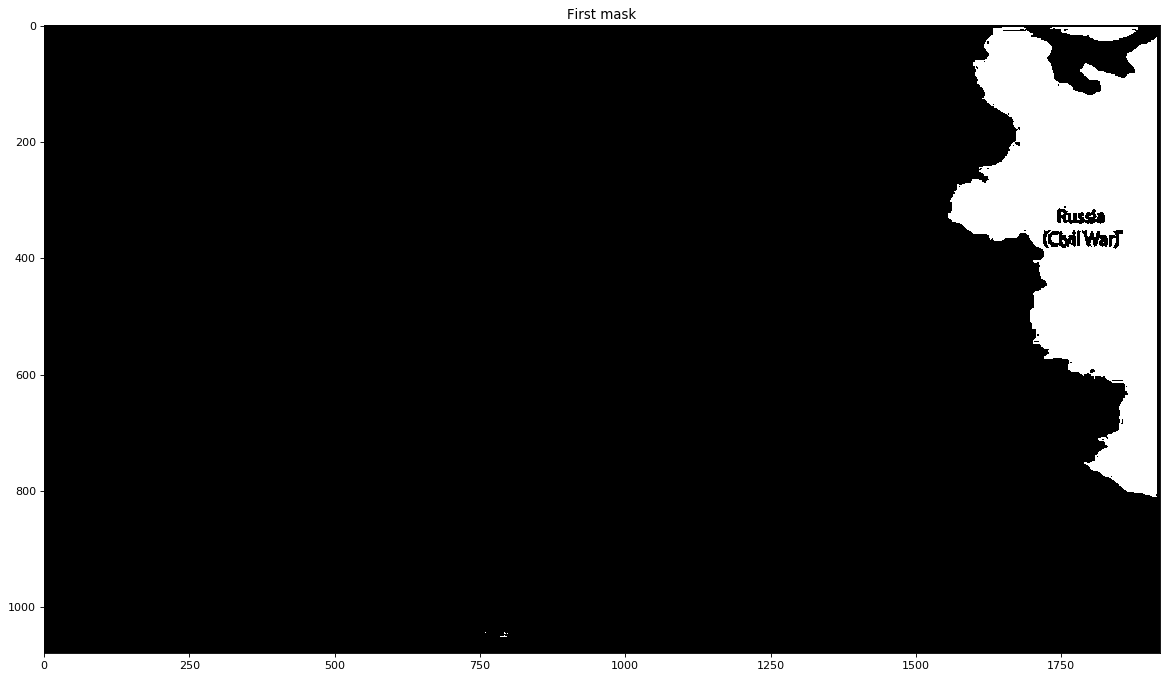

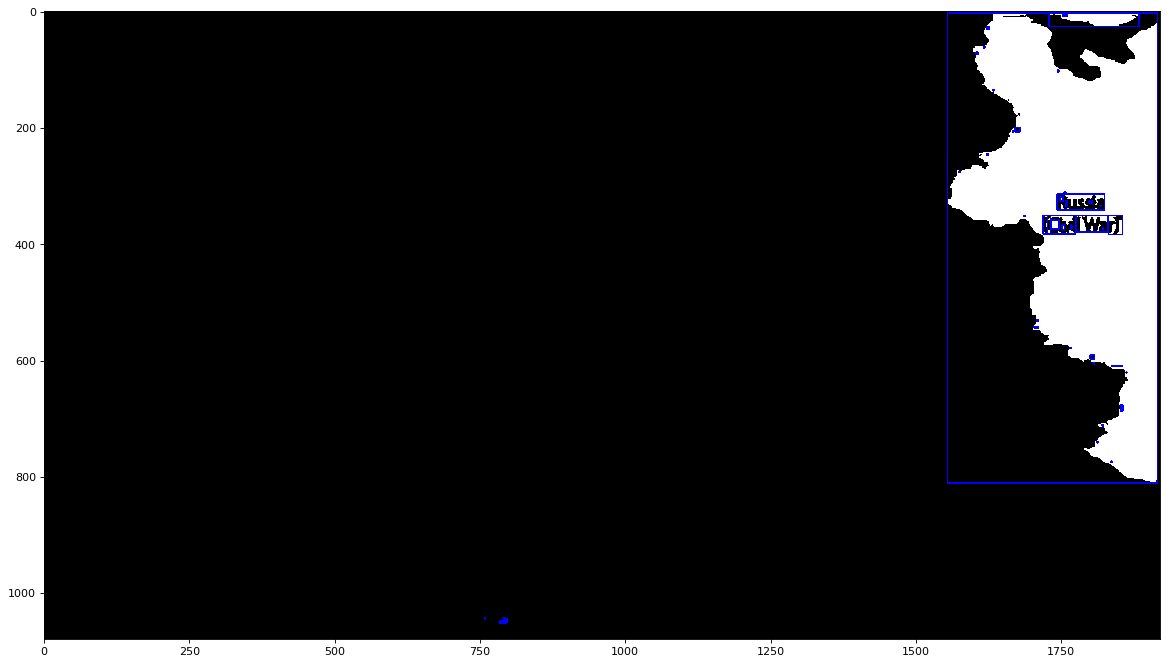

42 Polygons were extracted


In [11]:
from skimage import measure
from shapely.geometry import Polygon
import skimage.color
def get_polygons(mask):
    contours = measure.find_contours(mask, 0.8)
    return [Polygon(list(zip(contour[:, 1], contour[:, 0]))) for contour in contours]

def drawShape(img, coordinates, color) :
    # In order to draw our line in red
    img = skimage.color.gray2rgb(img)

    # Make sure the coordinates are expressed as integers
    coordinates = coordinates.astype(int)

    img[coordinates[:, 0], coordinates[:, 1]] = color

    return img

display_img(masks[0], 'First mask', True)
detected_polygons = get_polygons(masks[0])
disp_polygons(skimage.color.gray2rgb(masks[0]), detected_polygons)
print(len(detected_polygons), "Polygons were extracted")

Some polygons are significant and represent a country. Many of them are just pollution.  
Mainly :
1. Some small dots are detected
2. Letters representing the countries are detected  
  
  
They can be removed by : 
1. Removing the polygons which have a little area
2. Removing the polygons which lie into other polygons


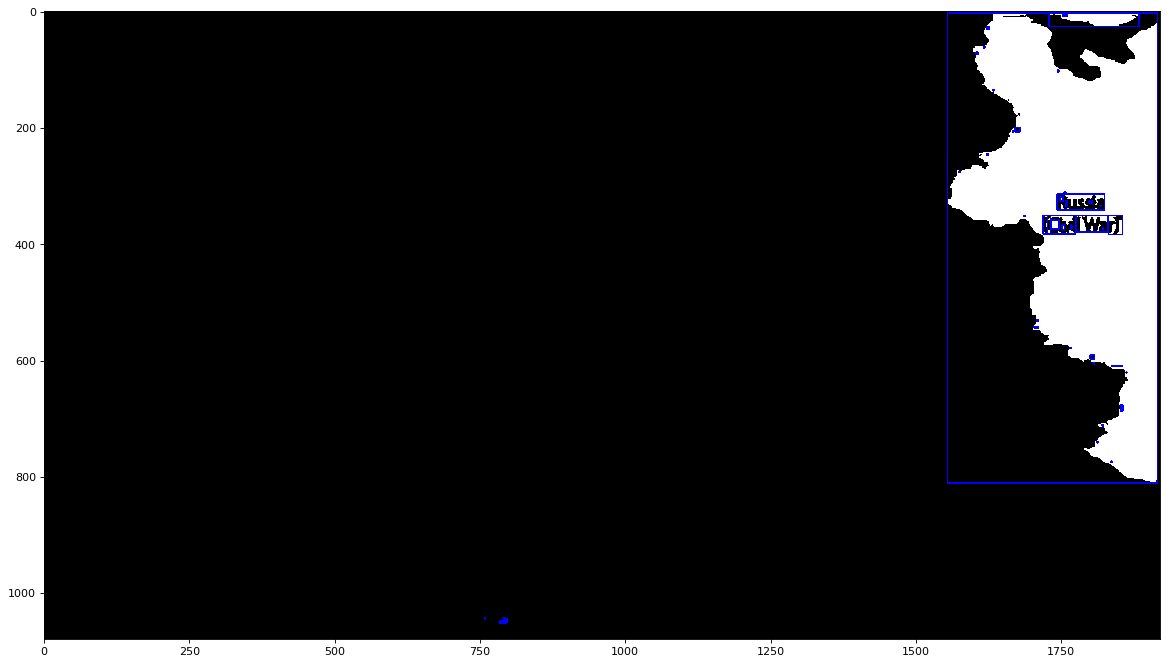

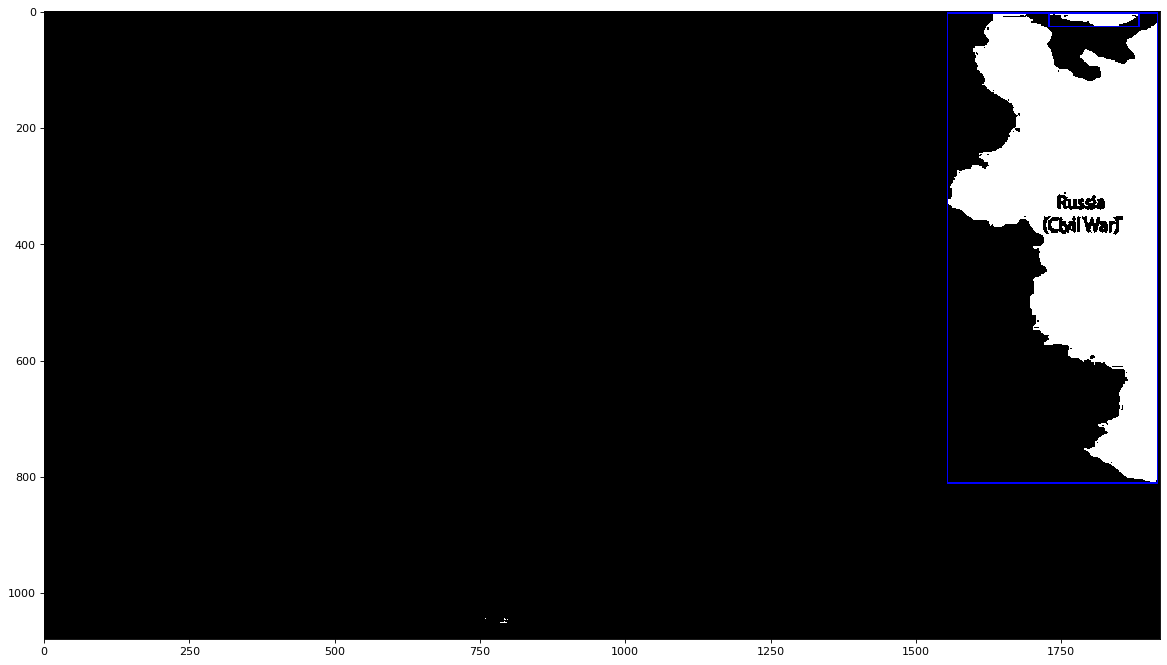

Kept  2 polygons


In [12]:
import skimage.draw
def is_contained(polygon, other_polygons):
    for potential_container in other_polygons:
        if polygon.within(potential_container):
            return True
    return False

def is_significant(polygon, mask):
    return is_big_enough(polygon) and not is_letter(polygon, mask)

def filter_polygons(polygons):
    big_polygons = [pol for pol in polygons if pol.area > 60]
    res = []
    for i, polygon in enumerate(big_polygons):
        if not is_contained(polygon, np.concatenate((big_polygons[:i], big_polygons[i+1:]))):
            res.append(polygon)
    return res

found_poly = get_polygons(masks[0])
disp_polygons(color.gray2rgb(masks[0]), found_poly)
kept_polygons = filter_polygons(found_poly)
disp_polygons(skimage.color.gray2rgb(masks[0]), kept_polygons)
print('Kept ', len(kept_polygons), 'polygons')

Now for every map

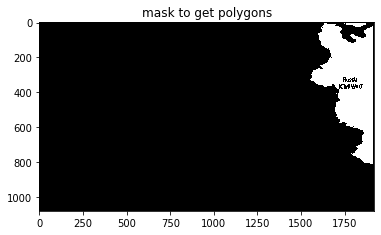

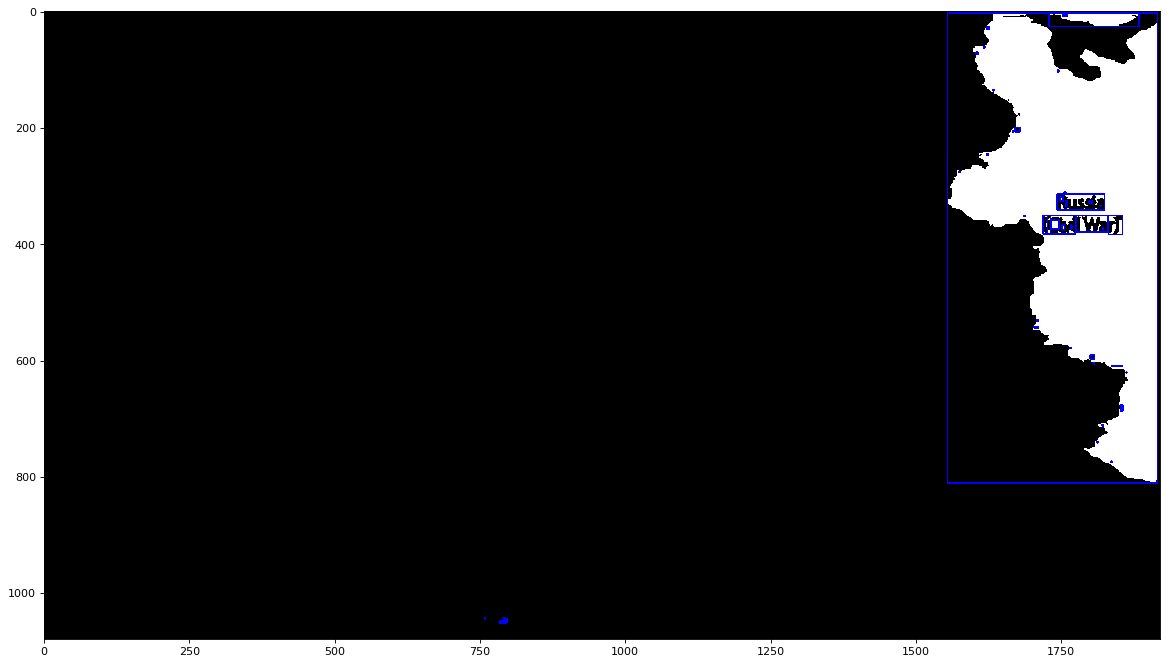

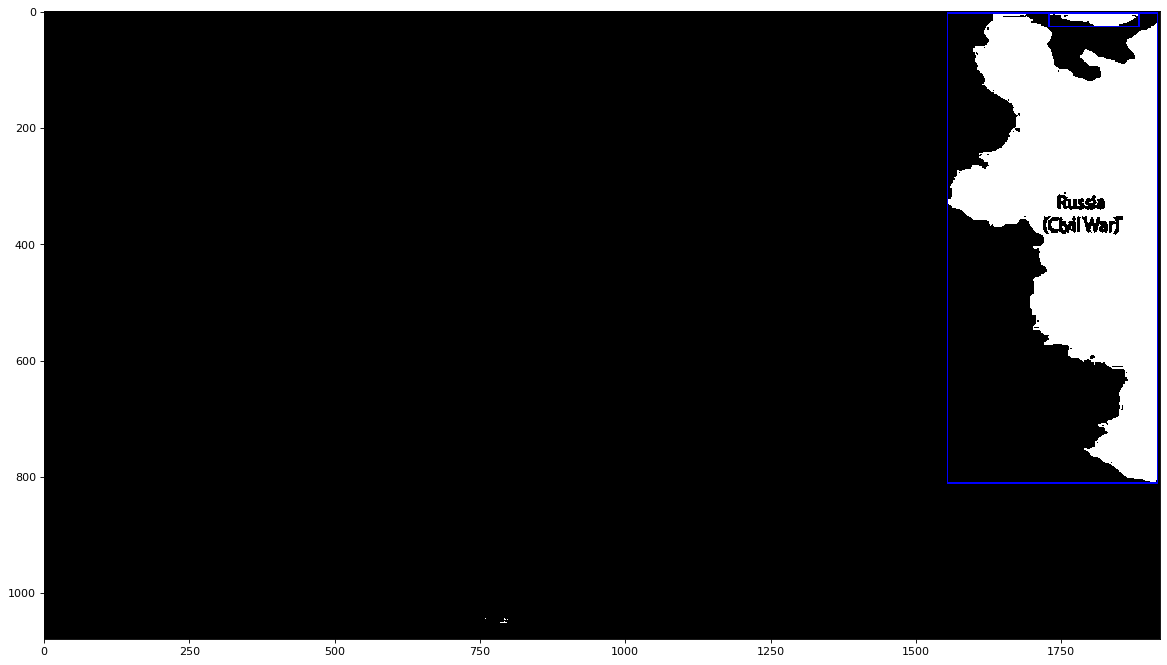

Kept  2 polygons


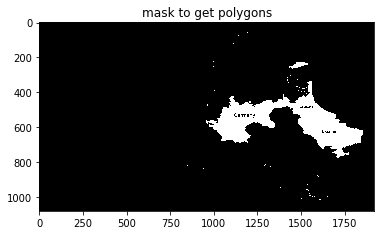

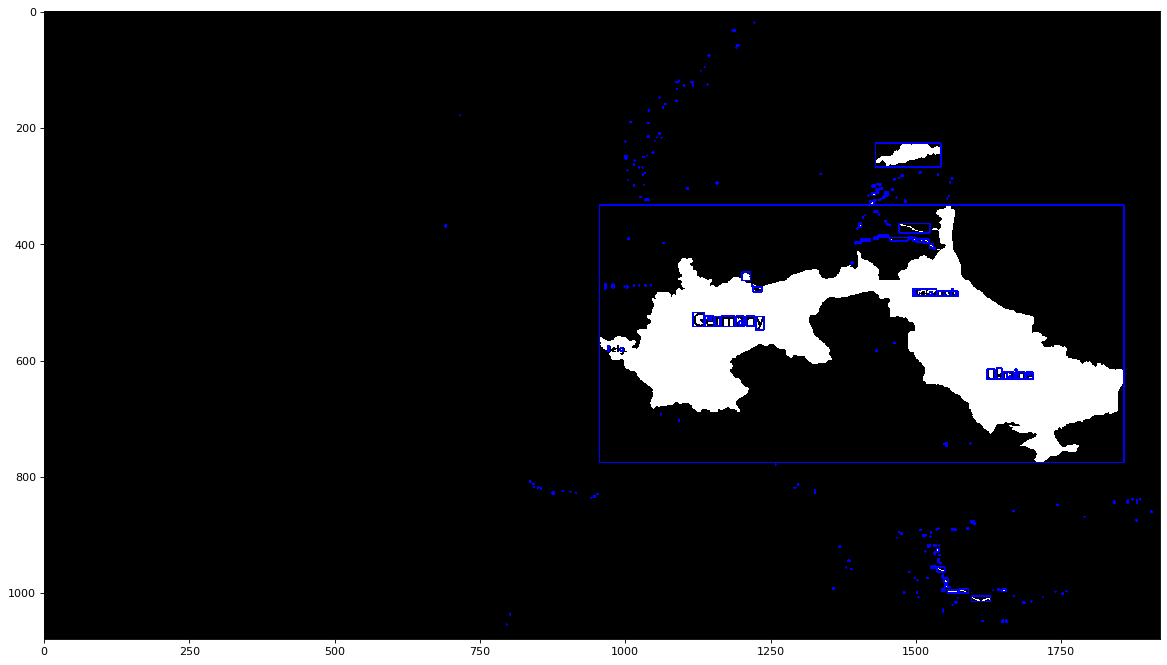

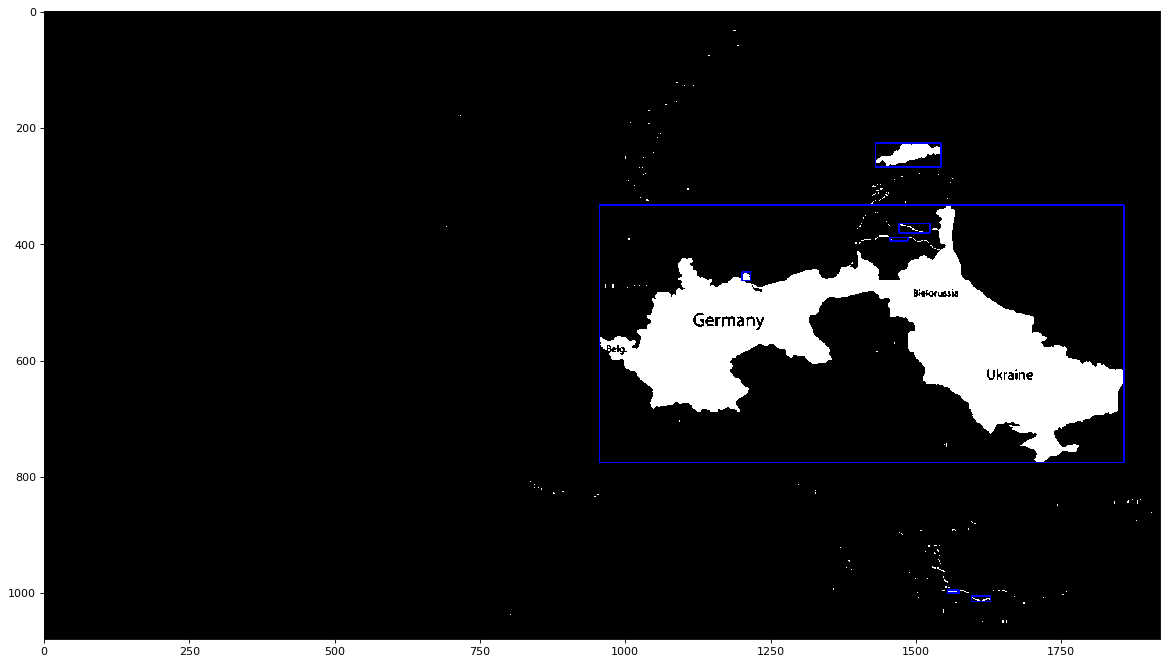

Kept  7 polygons


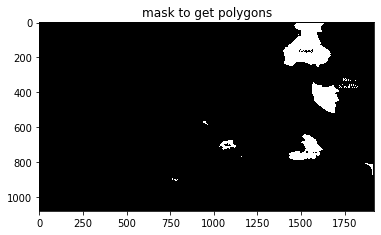

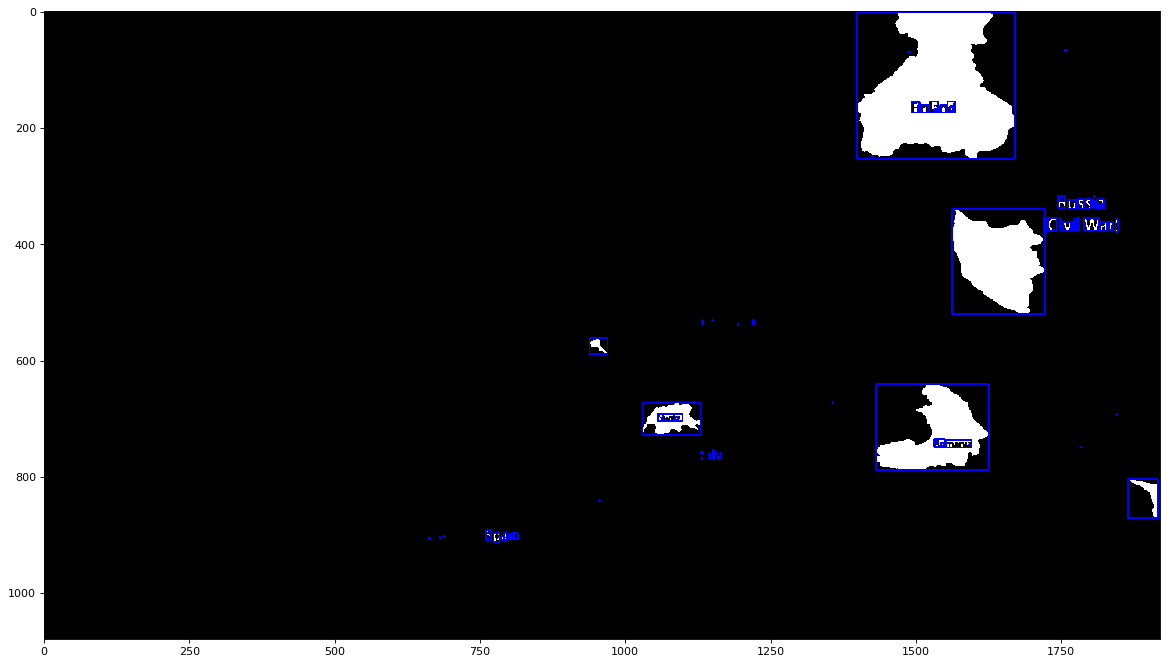

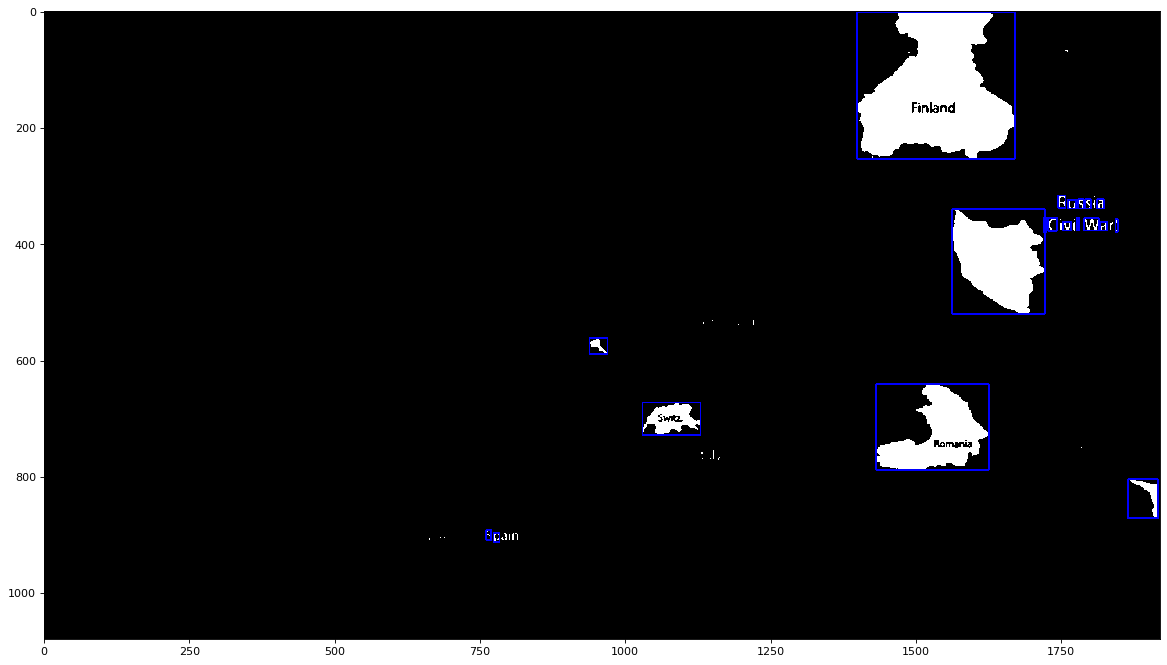

Kept  20 polygons


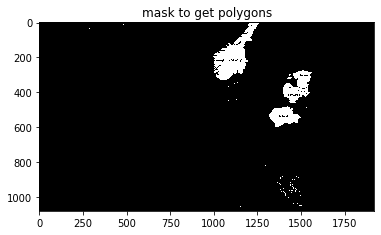

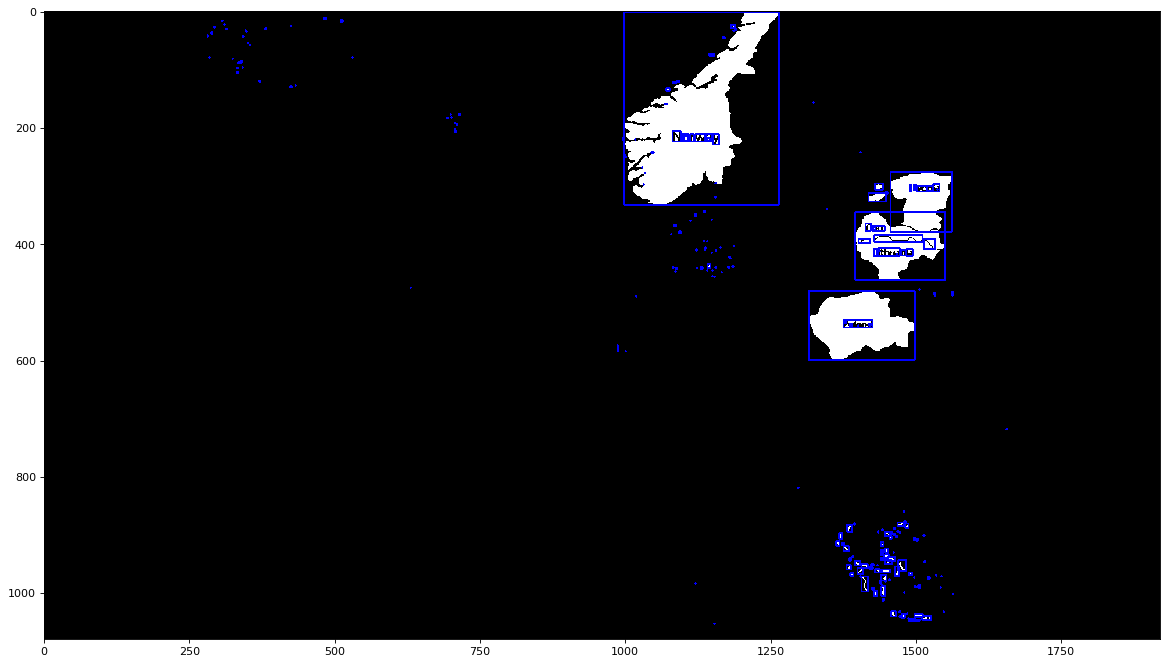

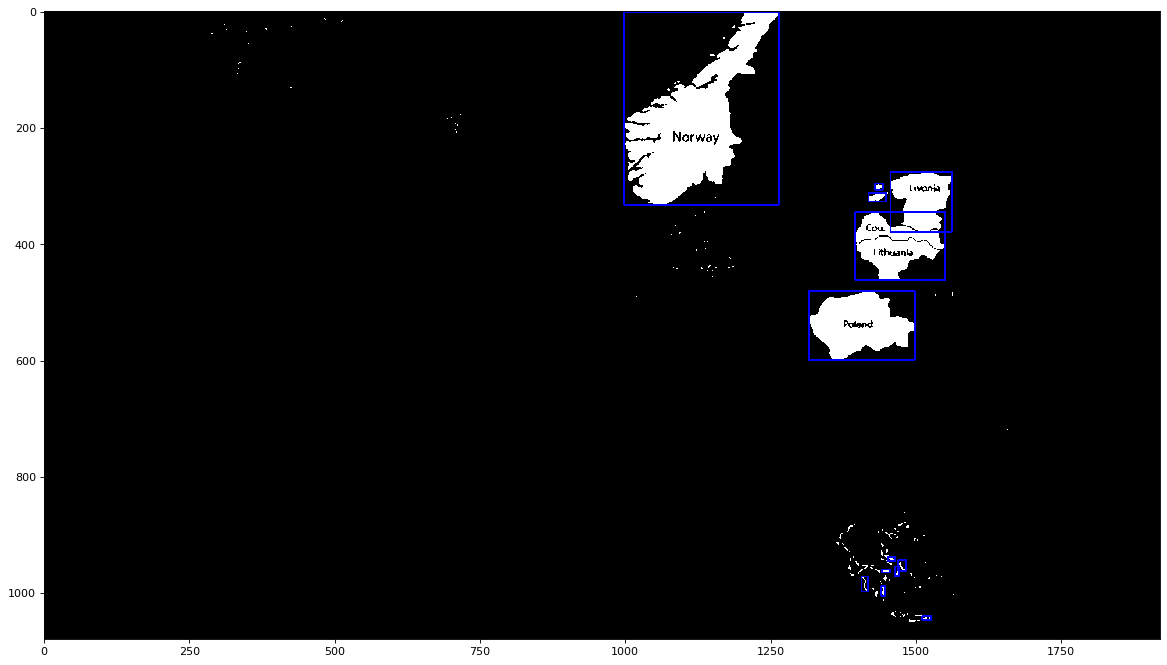

Kept  13 polygons


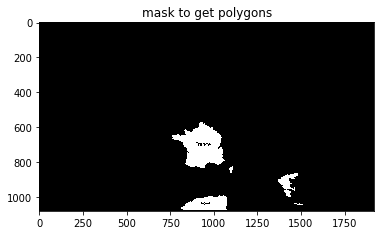

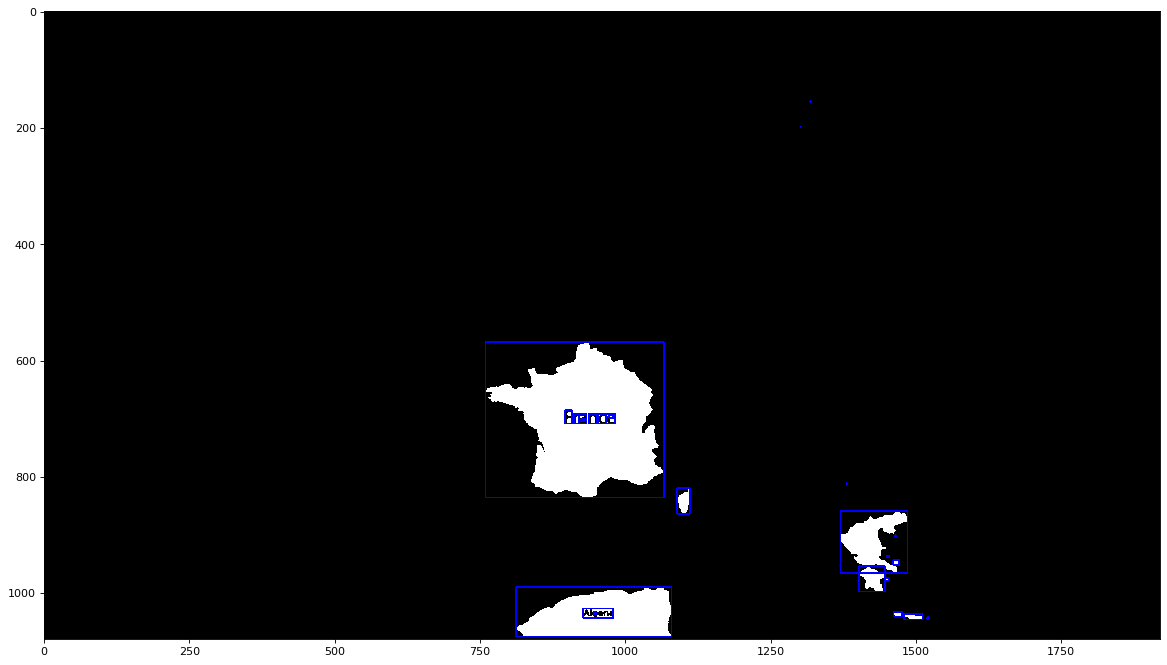

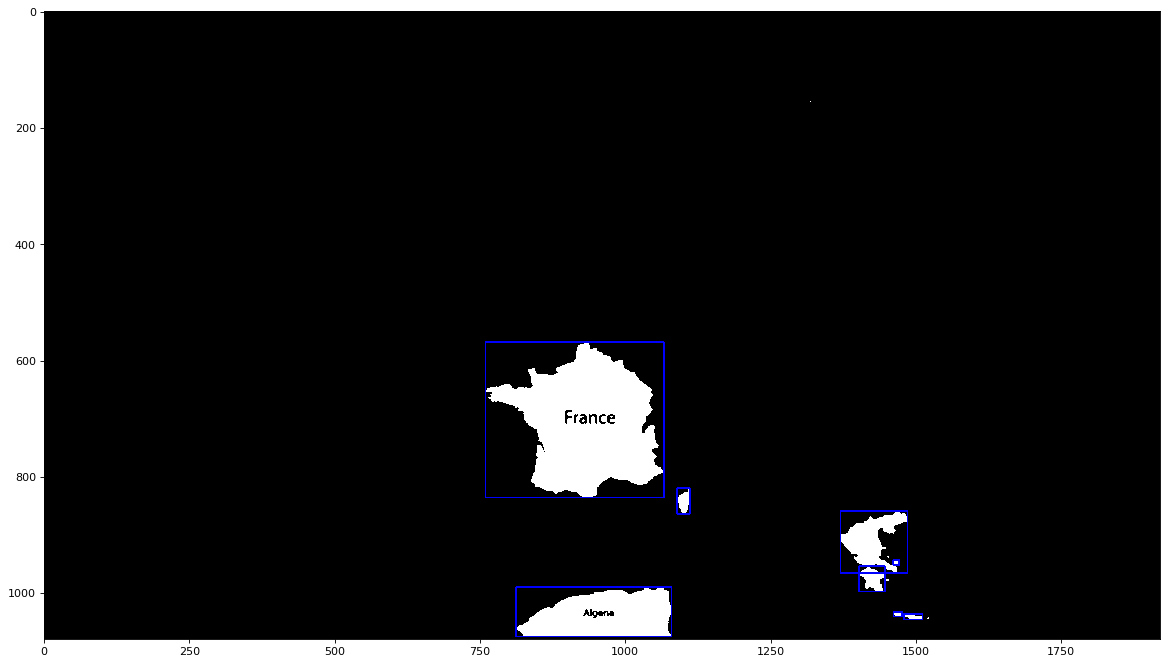

Kept  8 polygons


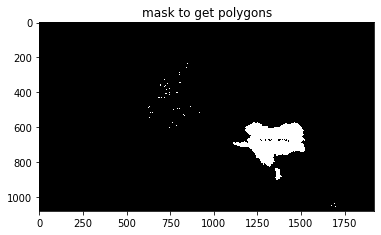

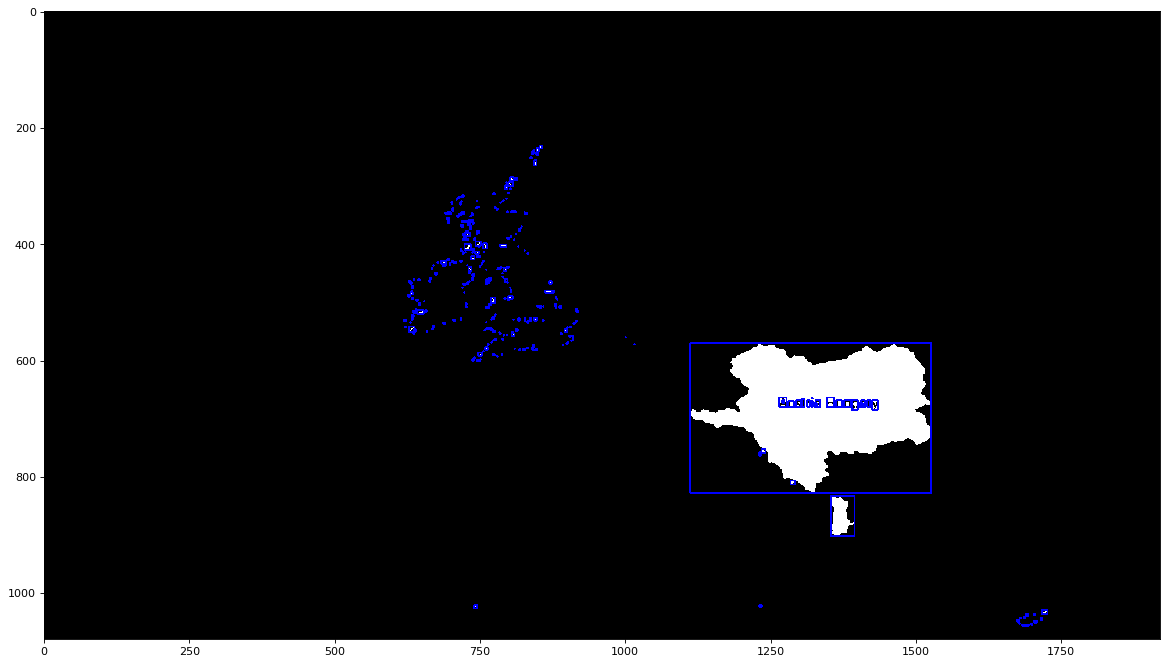

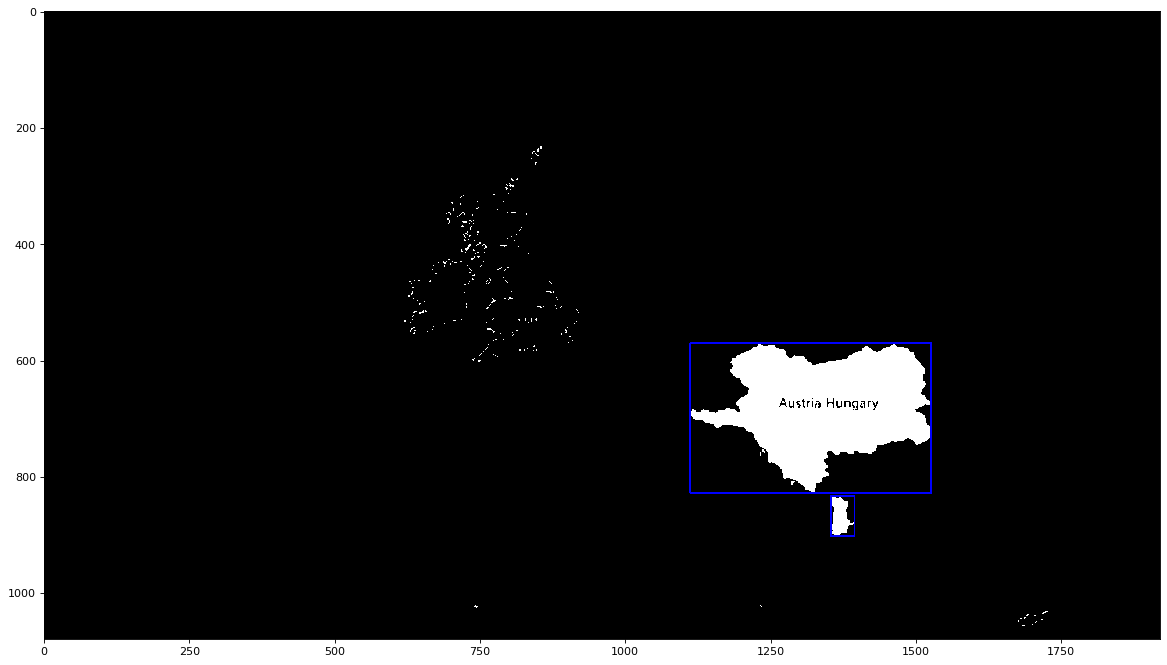

Kept  2 polygons


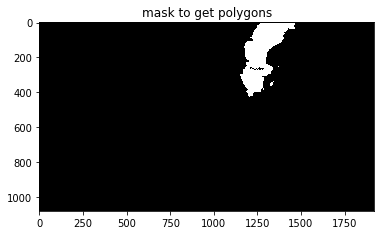

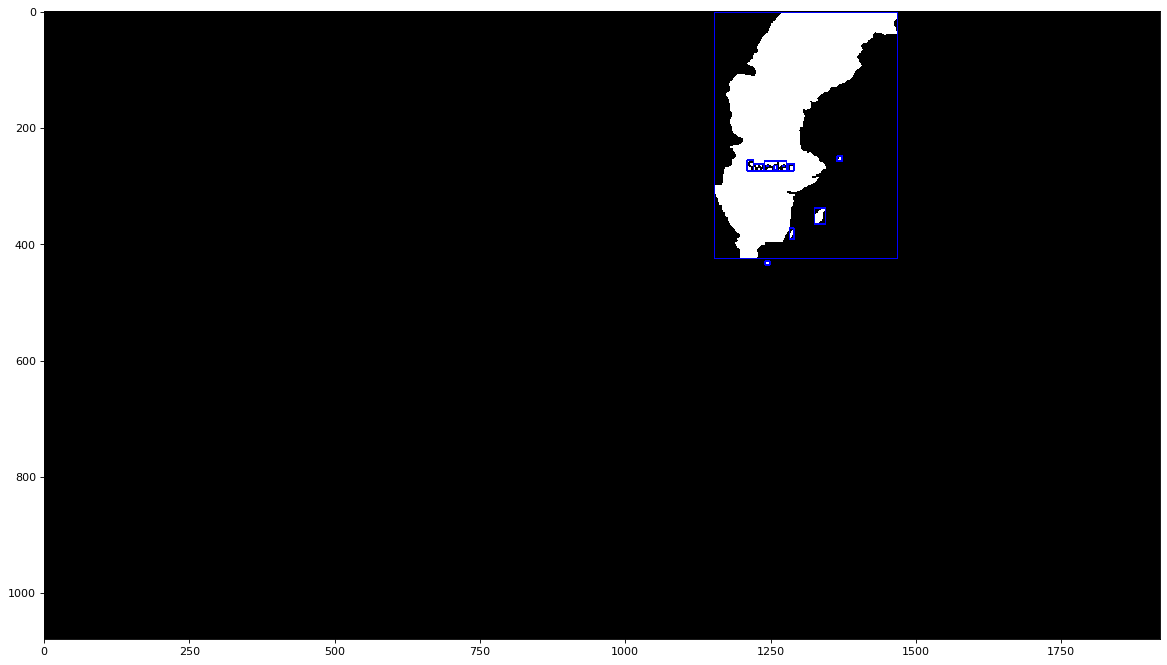

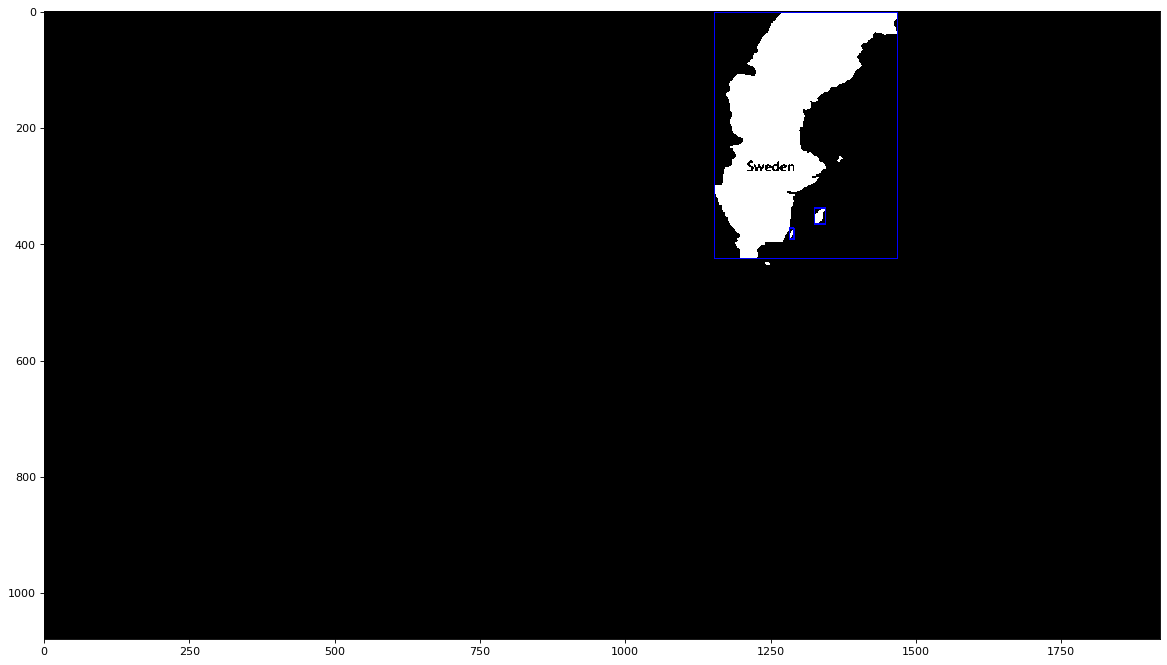

Kept  3 polygons


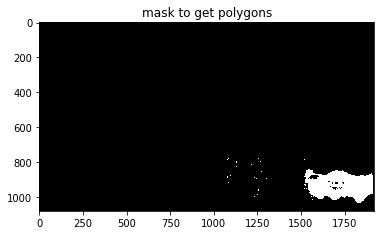

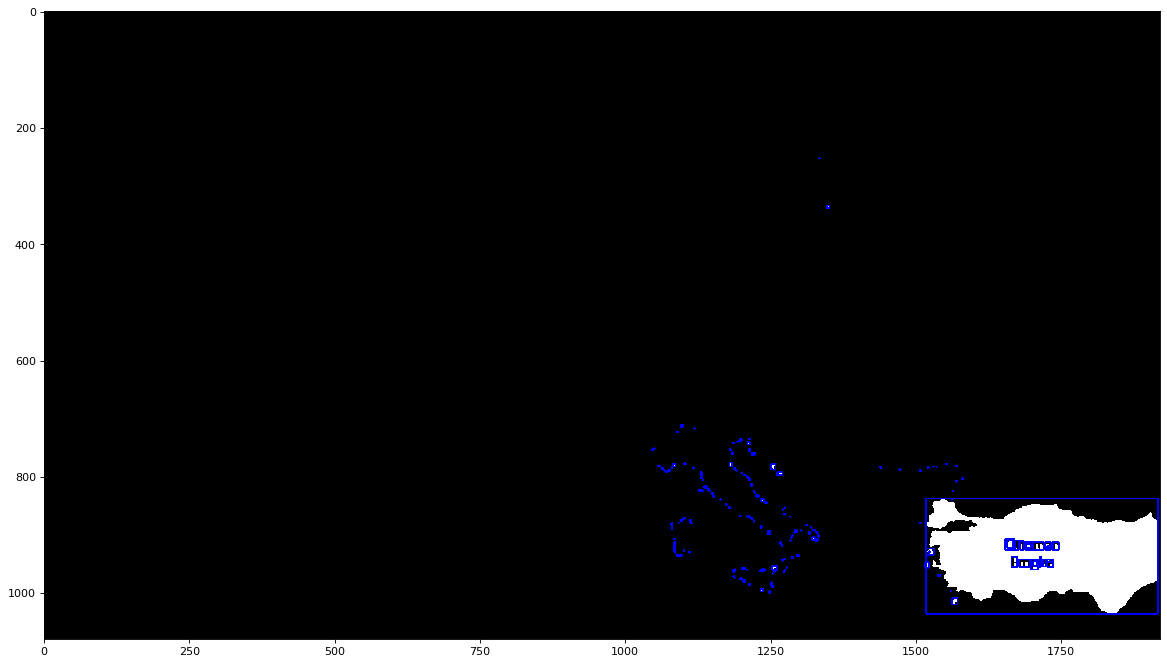

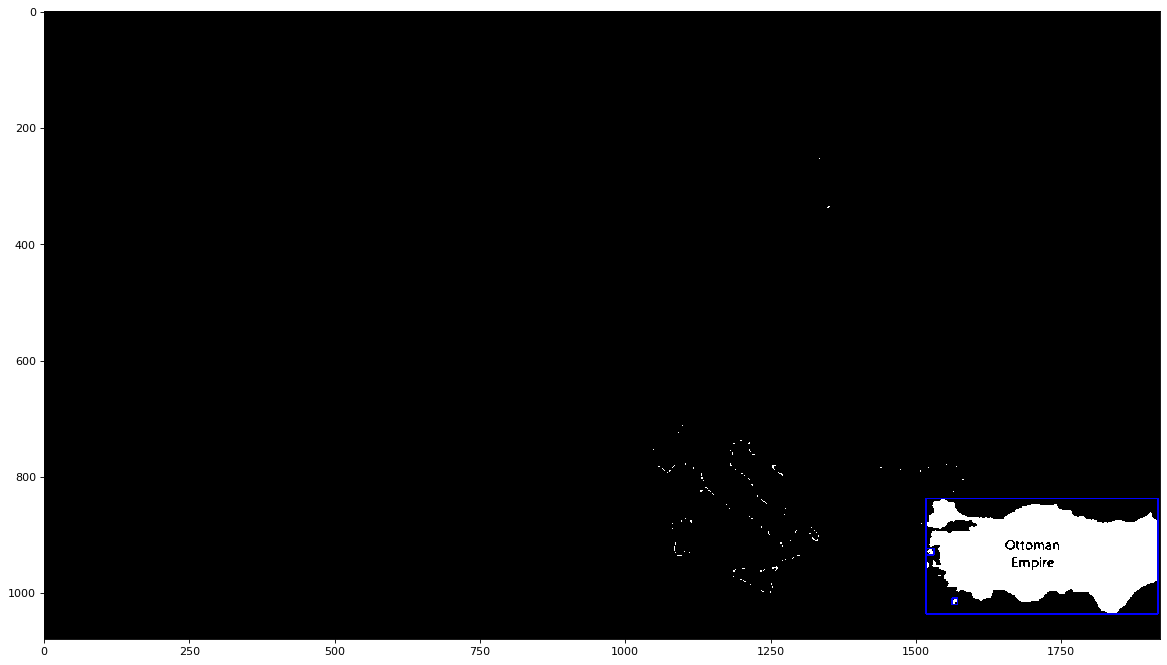

Kept  3 polygons


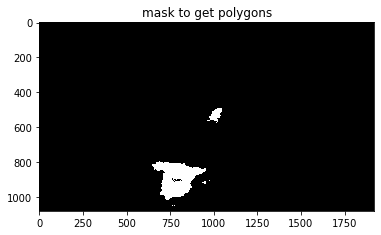

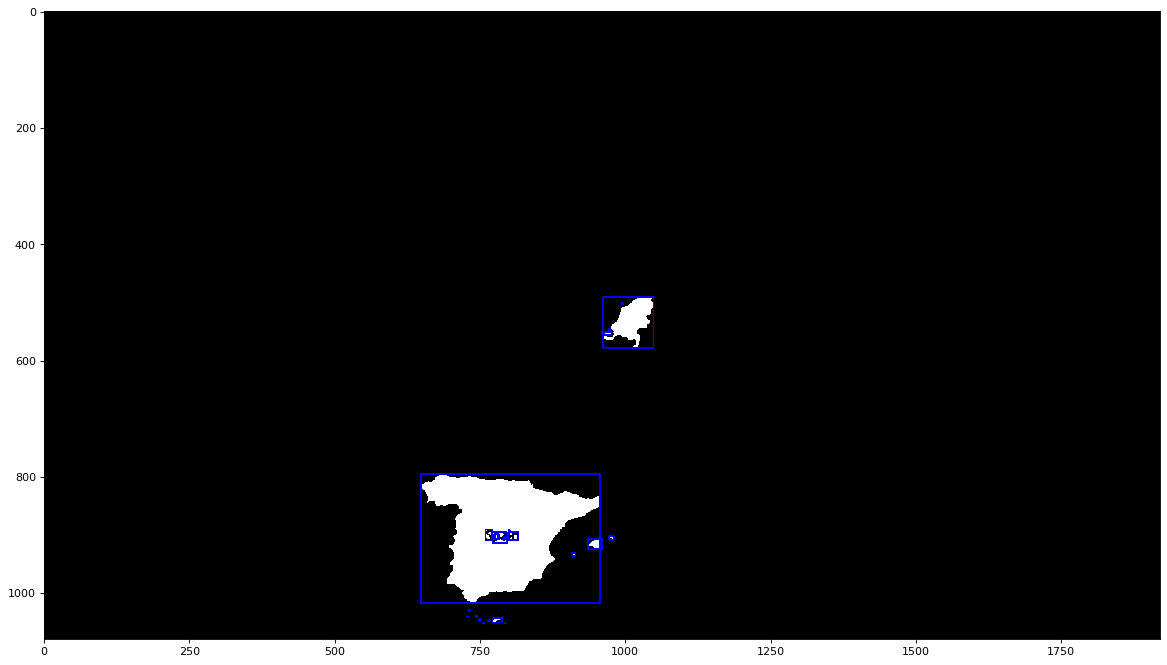

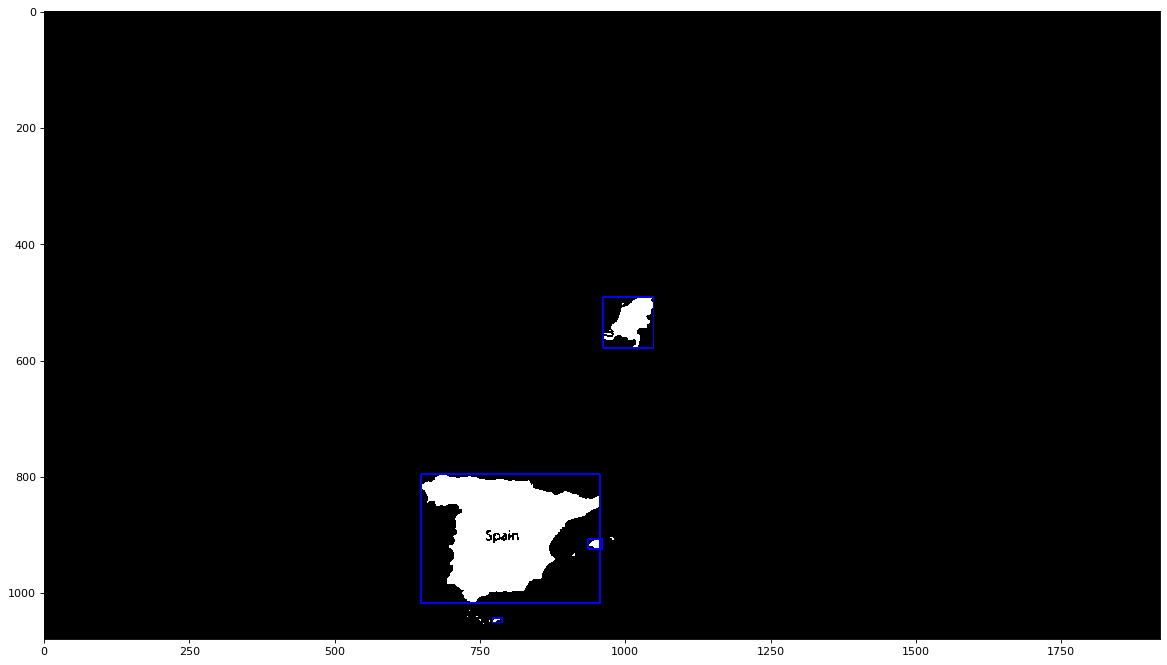

Kept  4 polygons


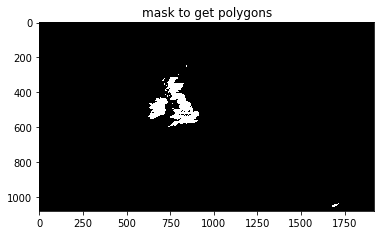

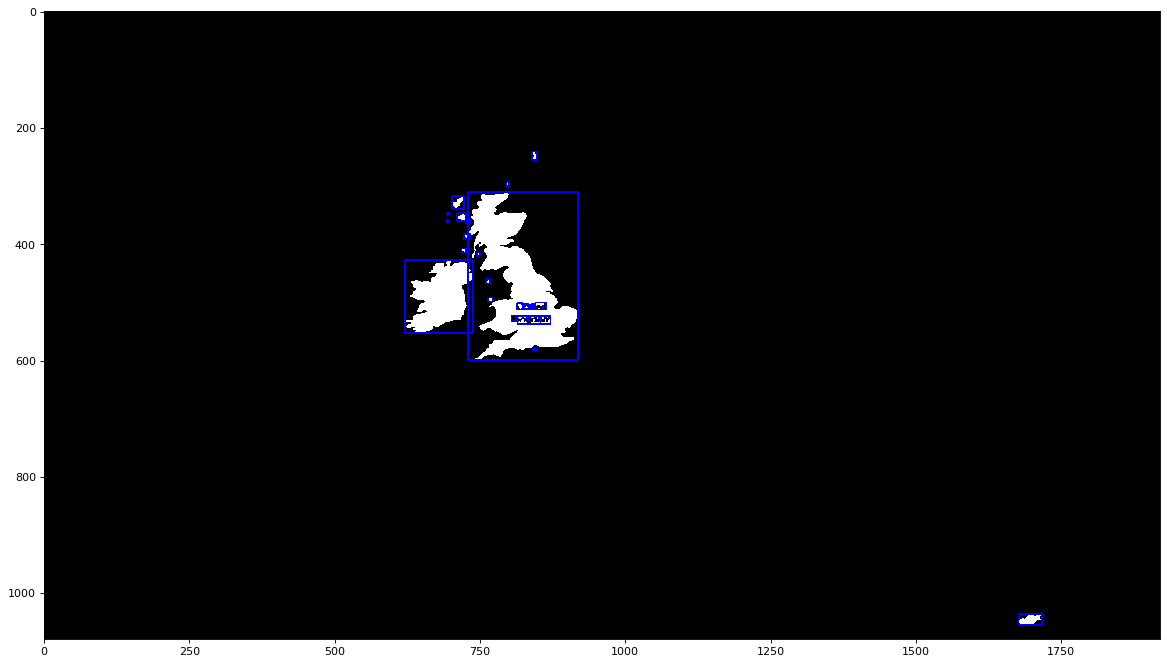

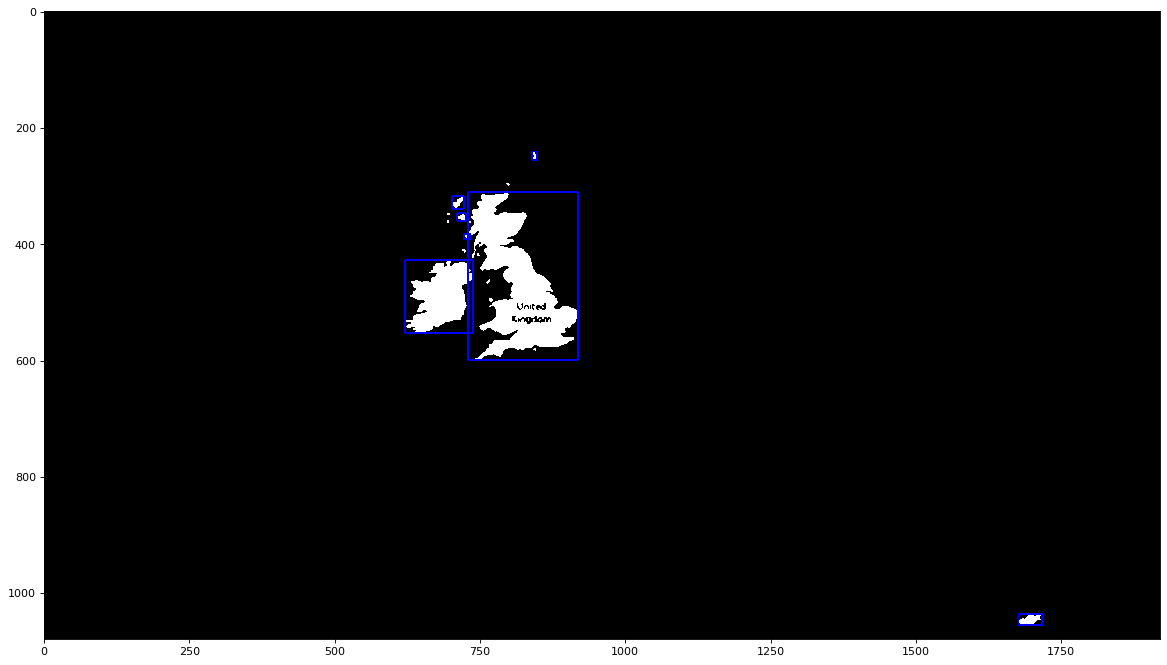

Kept  7 polygons


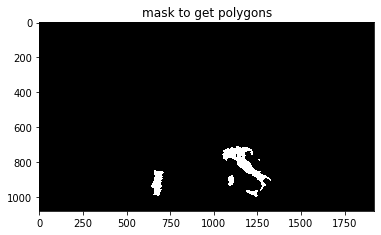

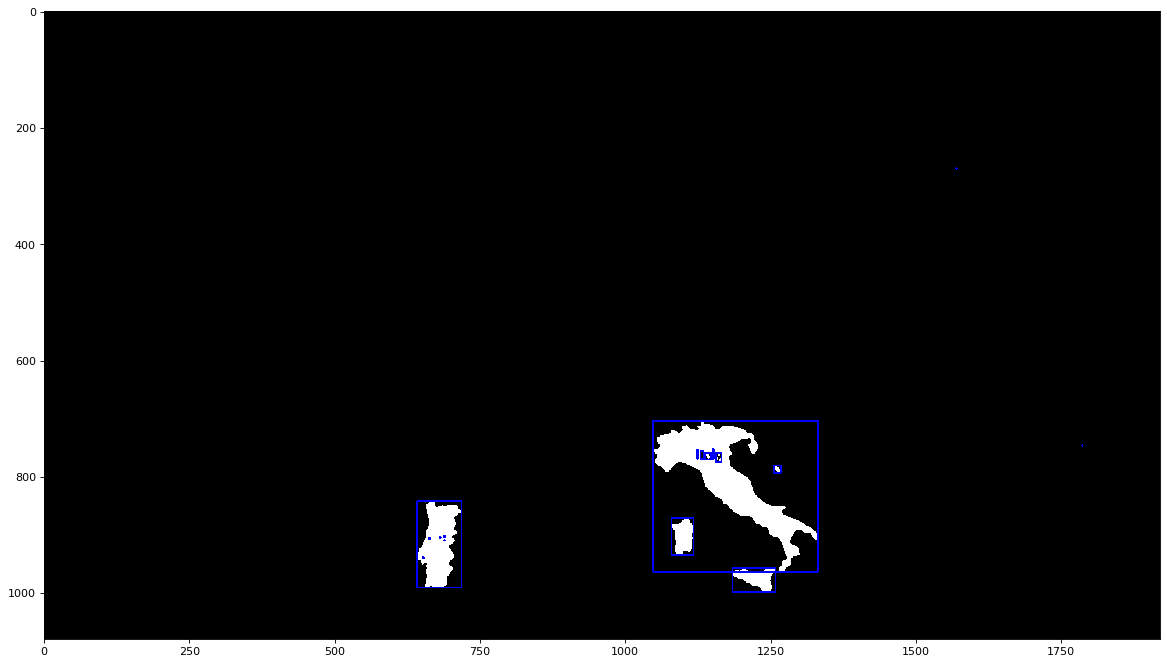

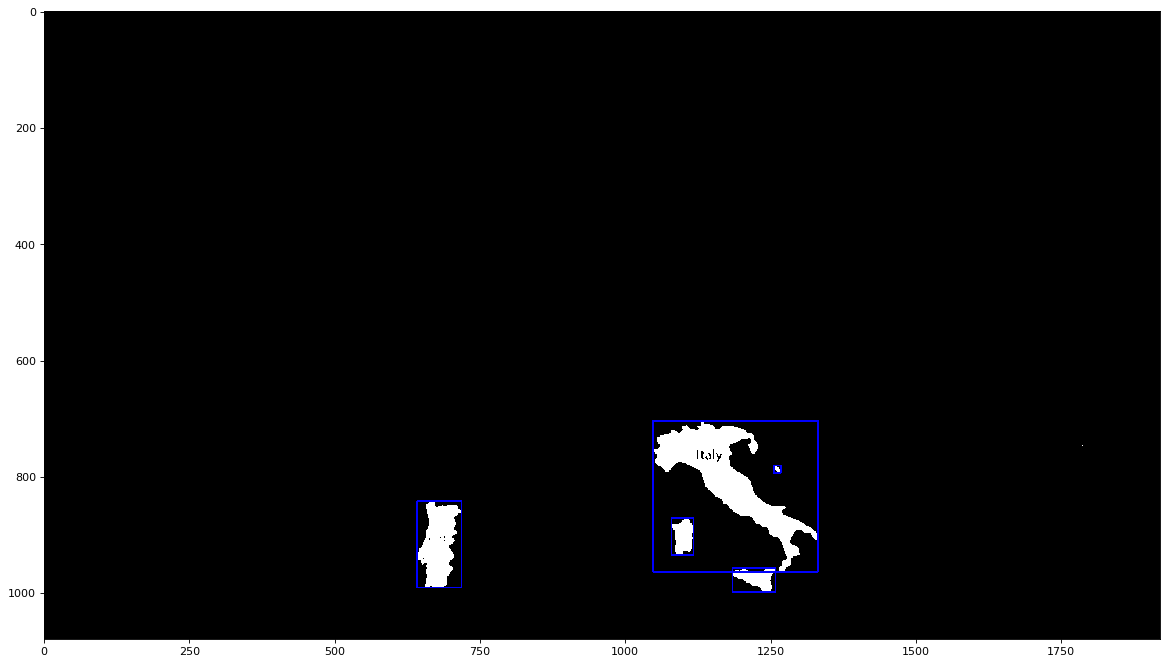

Kept  5 polygons


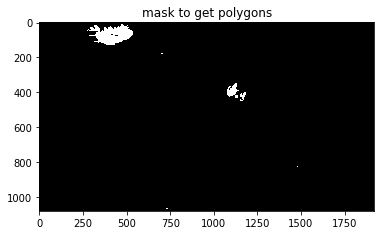

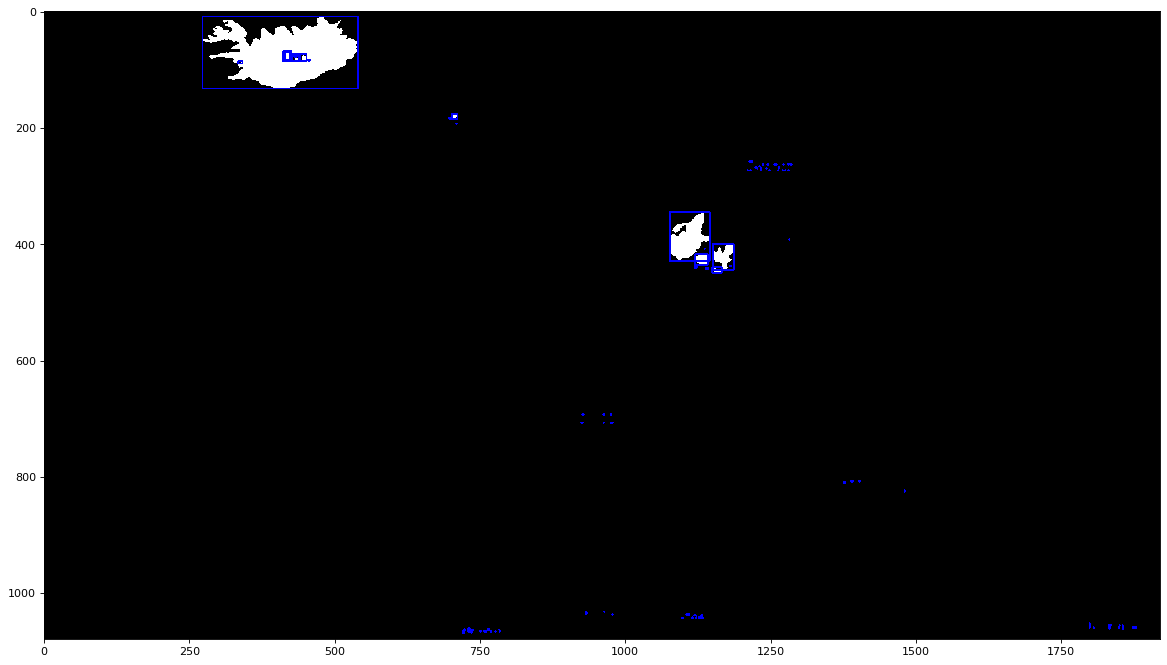

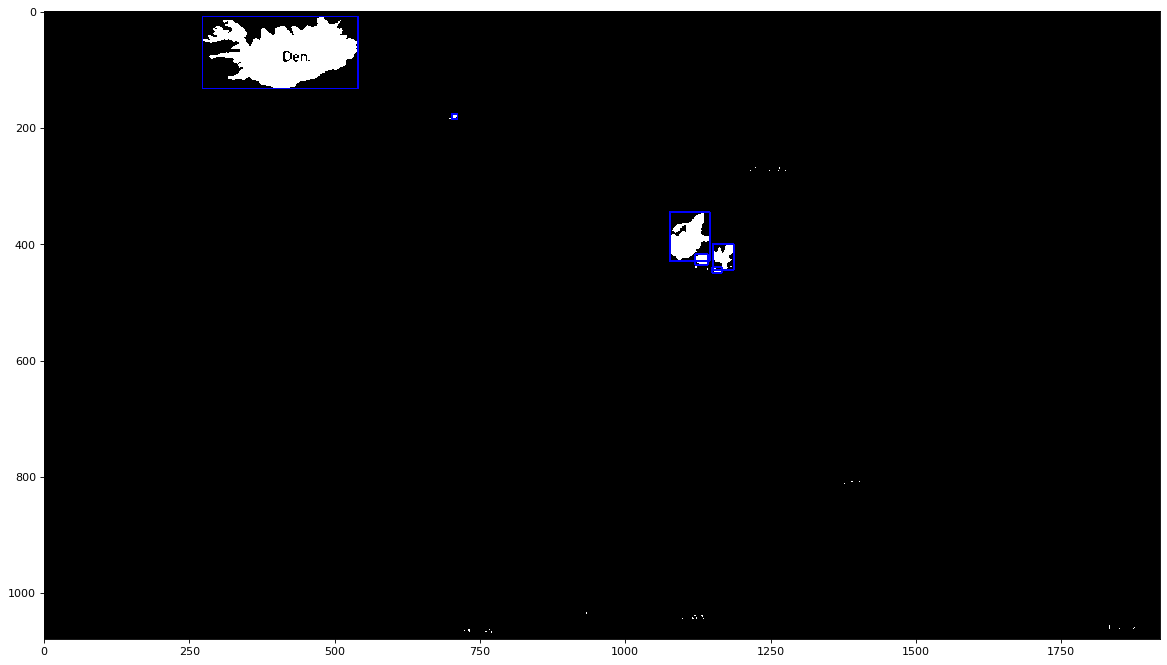

Kept  6 polygons


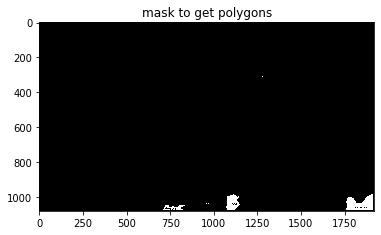

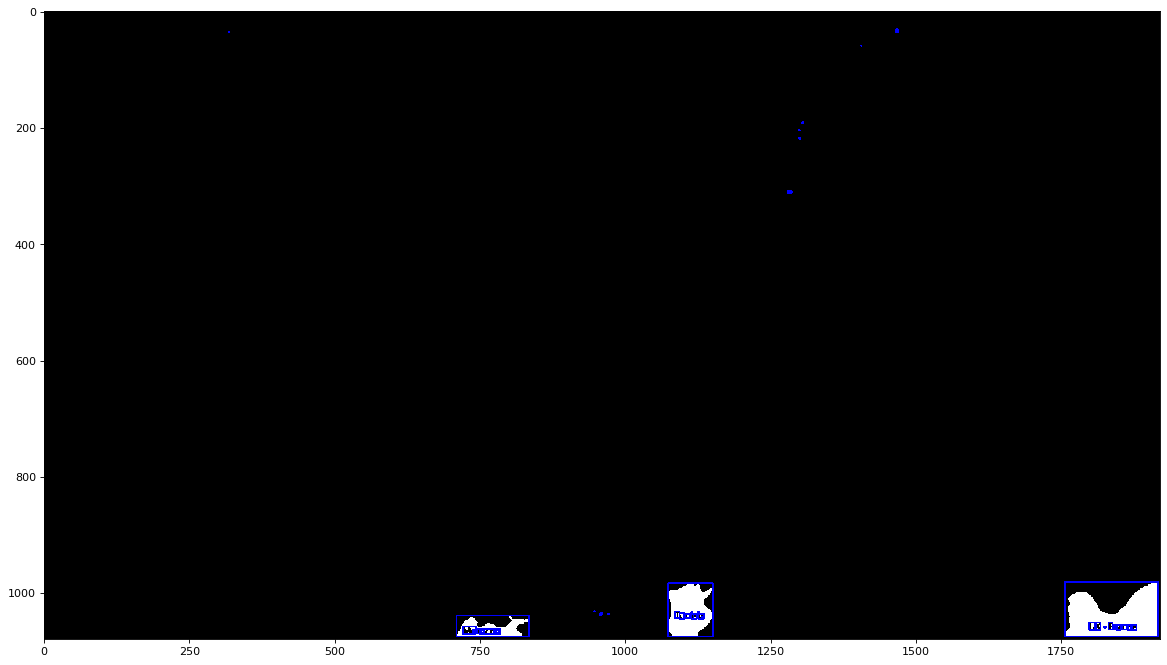

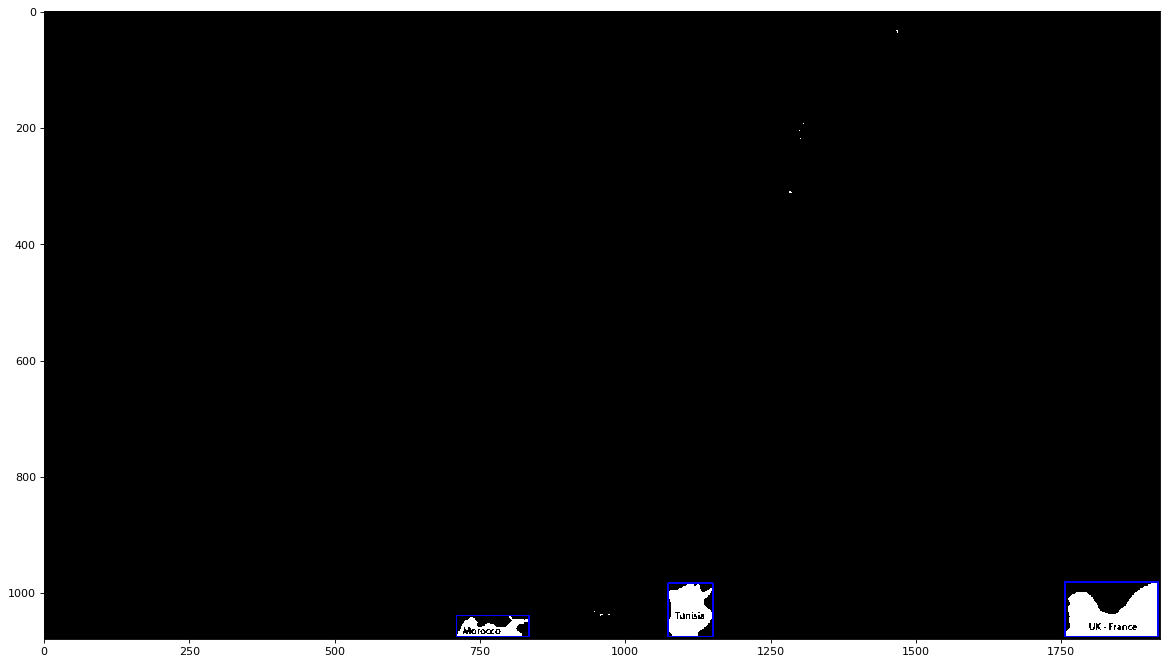

Kept  3 polygons


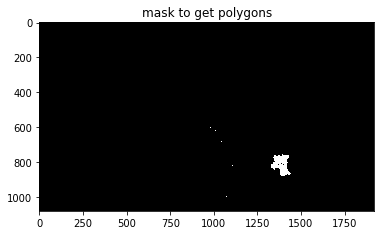

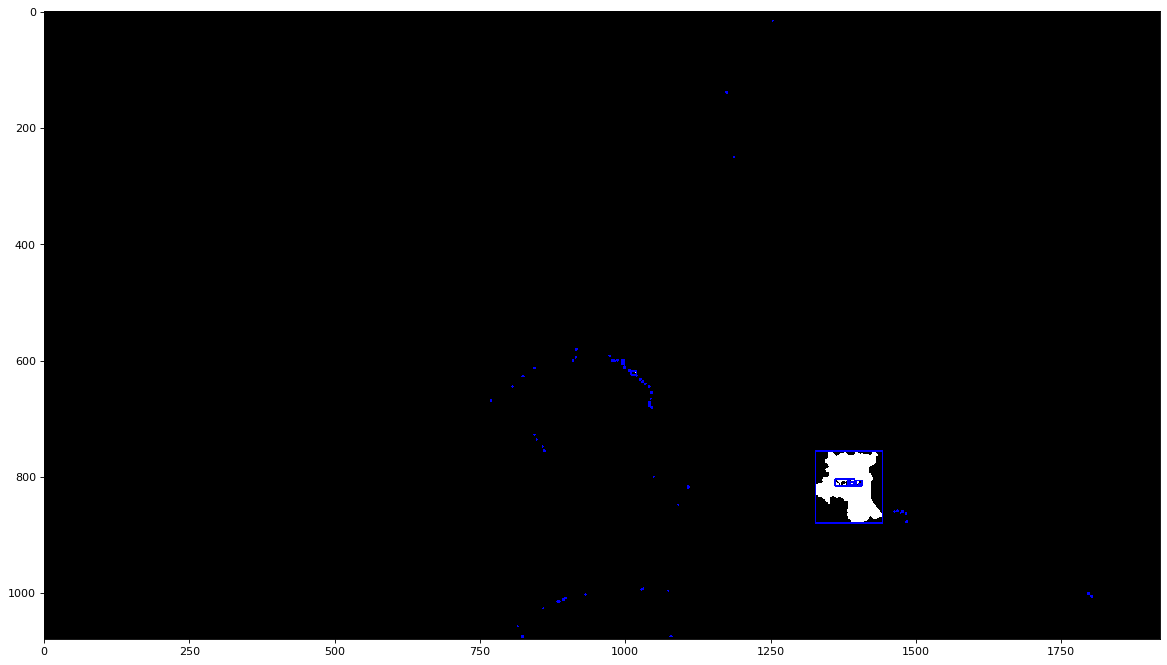

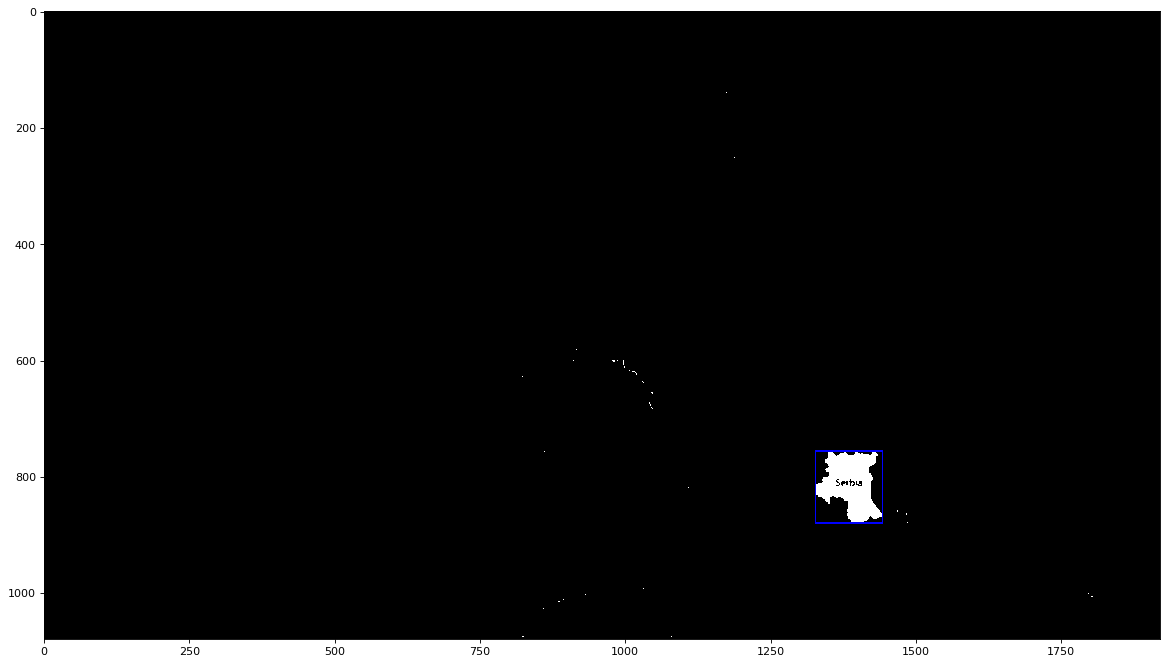

Kept  1 polygons


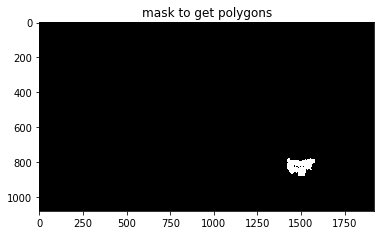

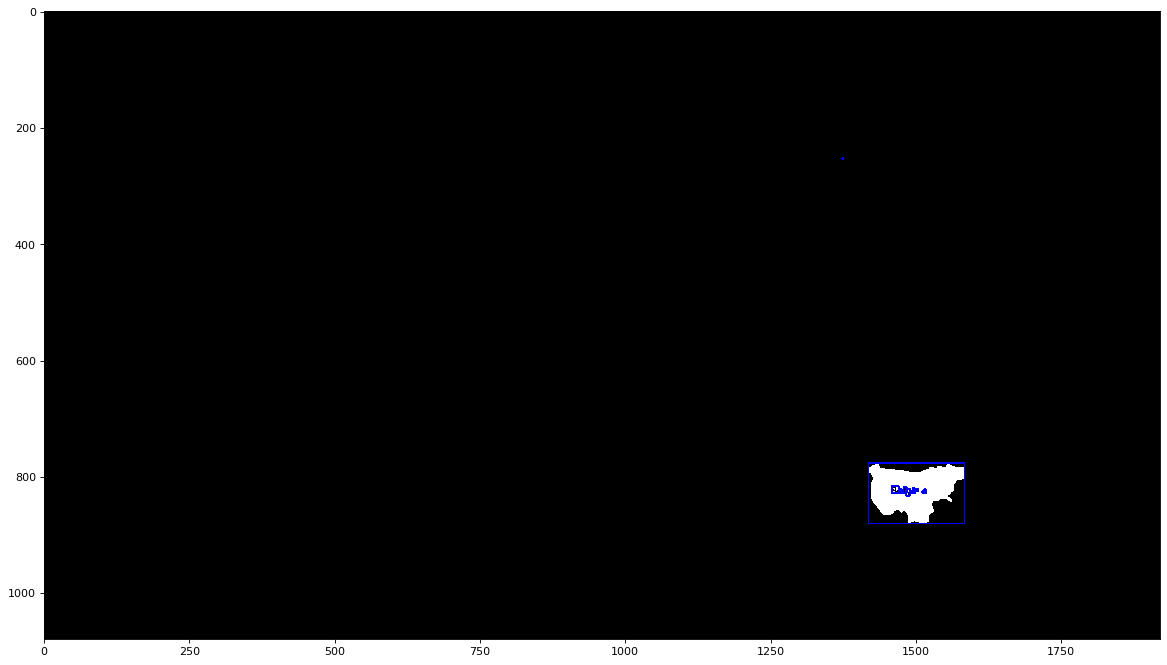

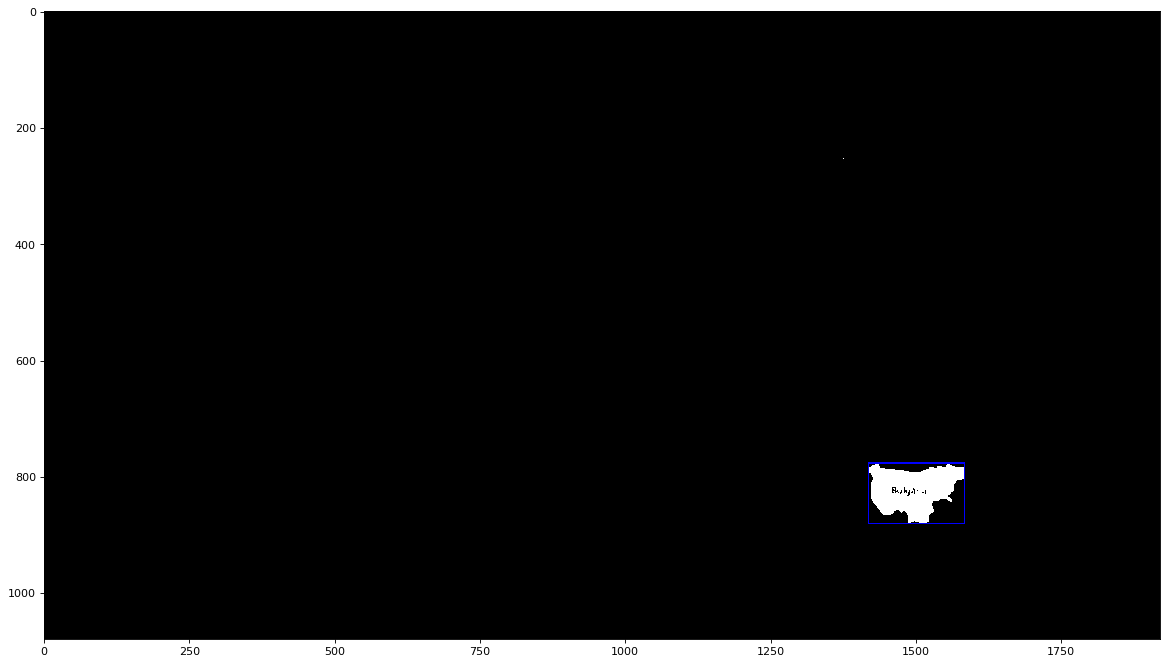

Kept  1 polygons


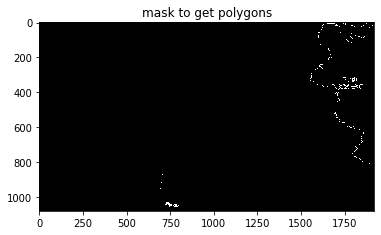

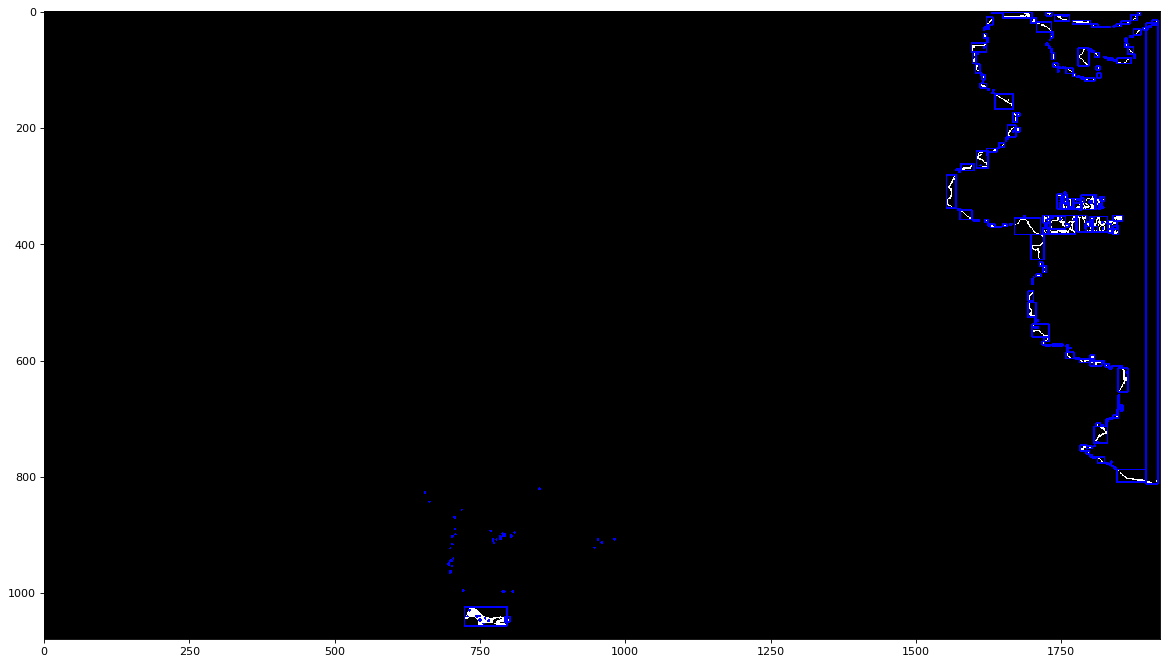

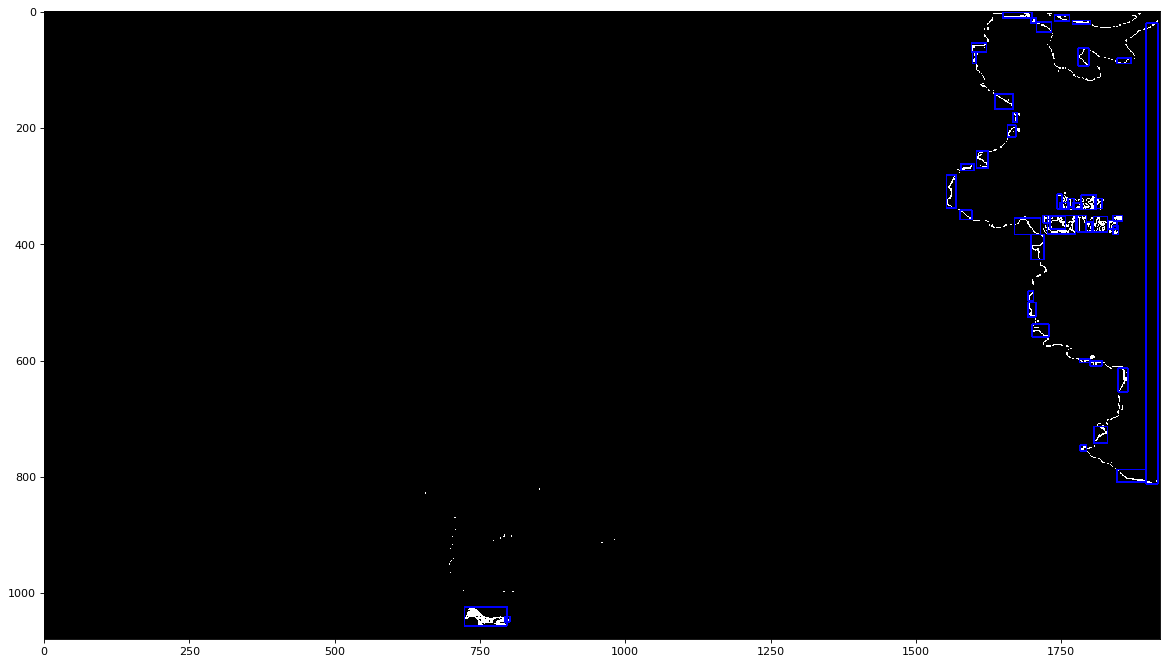

Kept  45 polygons


In [13]:
maps_countries = []
for mask in masks[:] :
    found_polygons = get_polygons(mask)
    display_img(mask, 'mask to get polygons')
    disp_polygons(skimage.color.gray2rgb(mask), found_polygons)
    kept_polygons = filter_polygons(found_polygons)
    maps_countries.append(kept_polygons)
    disp_polygons(skimage.color.gray2rgb(mask), kept_polygons)
    print('Kept ', len(kept_polygons), 'polygons')

In [14]:
end_time = time.time()
print('Elapsed time for notebook execution : ', end_time - start_time)

Elapsed time for notebook execution :  131.31144833564758


In [15]:
from tqdm.notebook import tqdm

def draw_polygons(img, polygons, color):
    res = img.copy()
    for polygon in polygons :
        coords = np.array(polygon.exterior.coords)
        rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
        res[rr, cc] = color
    return res

europe_filled_with_polygons = np.ones(europe.shape)
print(land_colors.shape)

for i, countryset in tqdm(enumerate(maps_countries), total=len(maps_countries)):
    europe_filled_with_polygons = draw_polygons(europe_filled_with_polygons, countryset, land_colors.iloc[i].color)


(18, 2)


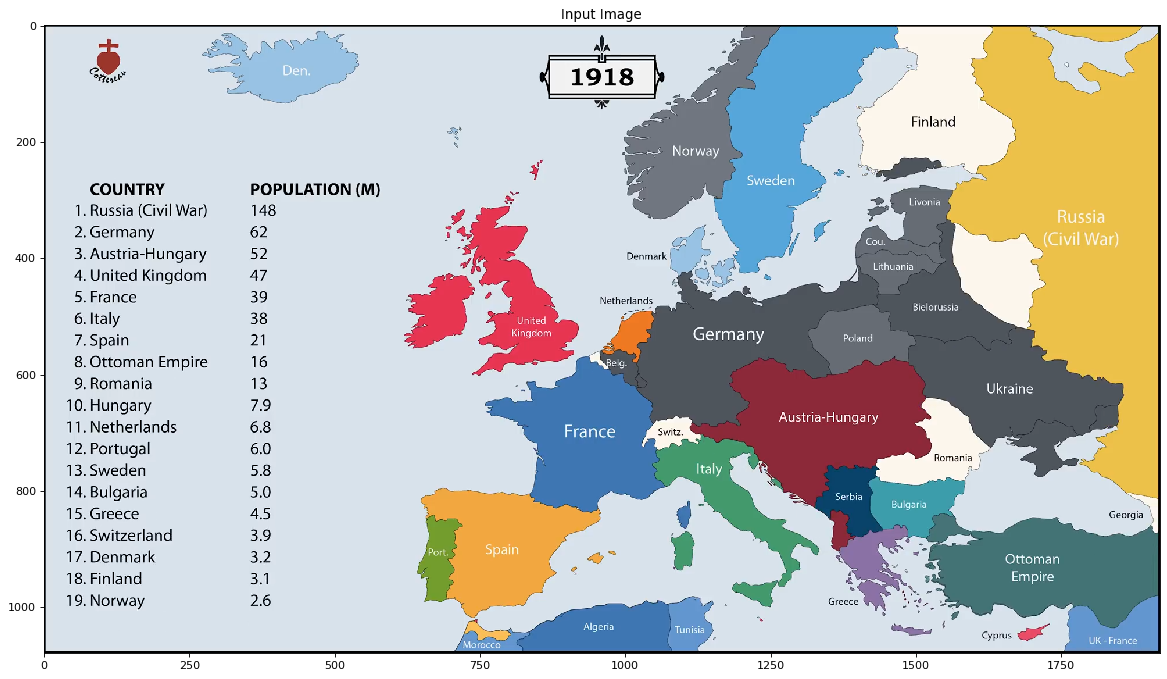

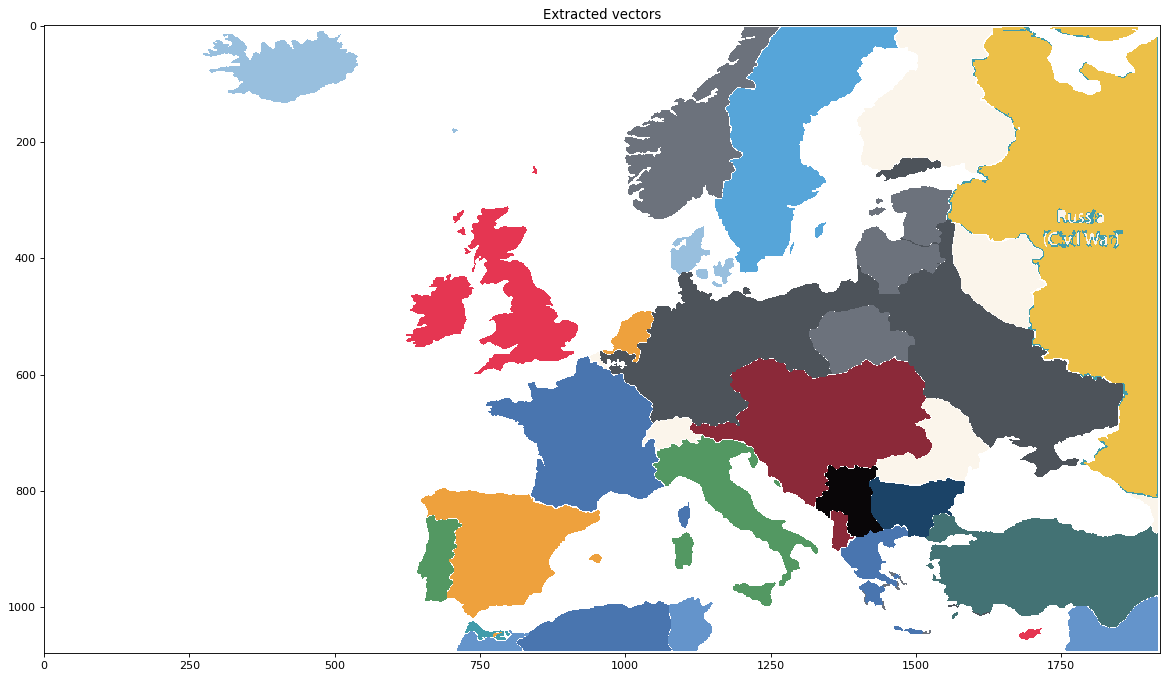

In [16]:
display_img(europe, 'Input Image', True)
display_img(europe_filled_with_polygons, 'Extracted vectors', True)

## Remove remaining pollution
There are still some shapes detected within another countries (such as in Russia for example).  
Let's remove them

0


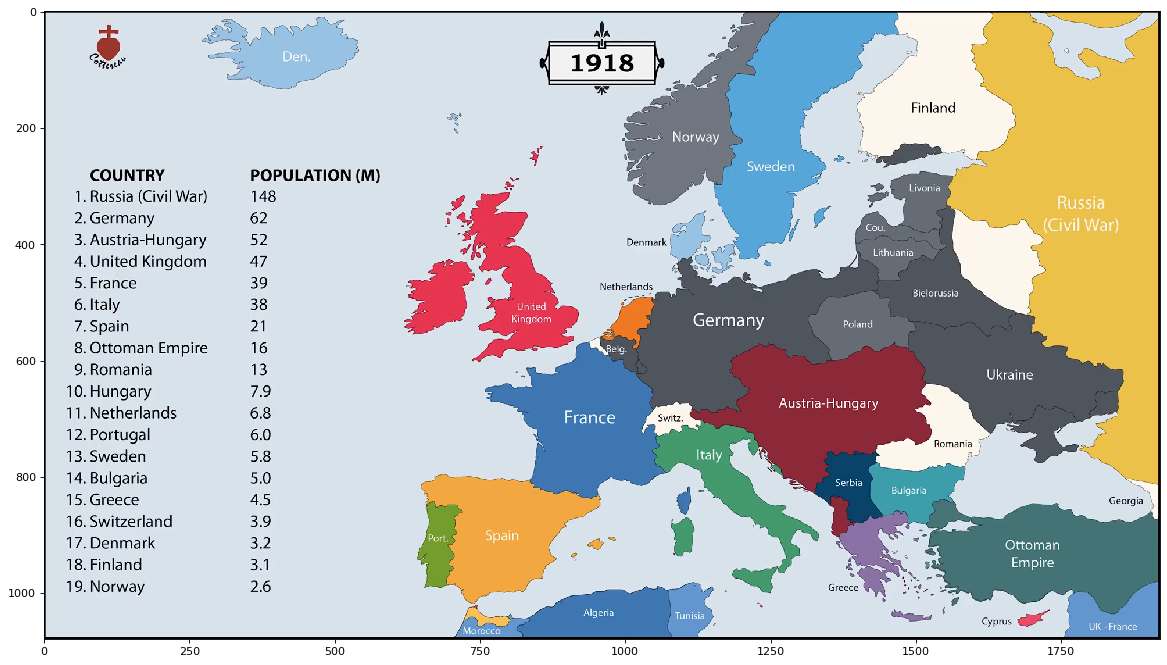

size maps countries before unsignificant removal 100
size maps countries after unsignificant removal 100


In [18]:
polygons_list = np.concatenate(maps_countries)
within_countries = []
for i in range(len(polygons_list)):
    polygon = polygons_list[i]
    others_polygons =np.concatenate((polygons_list[:i], polygons_list[i+1:]))
    if is_contained(polygon, others_polygons):
        within_countries.append(polygon)
            
print(len(within_countries))
disp_polygons(europe, within_countries)
print('size maps countries before unsignificant removal', len(np.concatenate(maps_countries)))
for i, countrylist in enumerate(maps_countries):
    maps_countries[i] = [country for country in countrylist if country not in within_countries] 
print('size maps countries after unsignificant removal', len(np.concatenate(maps_countries)))

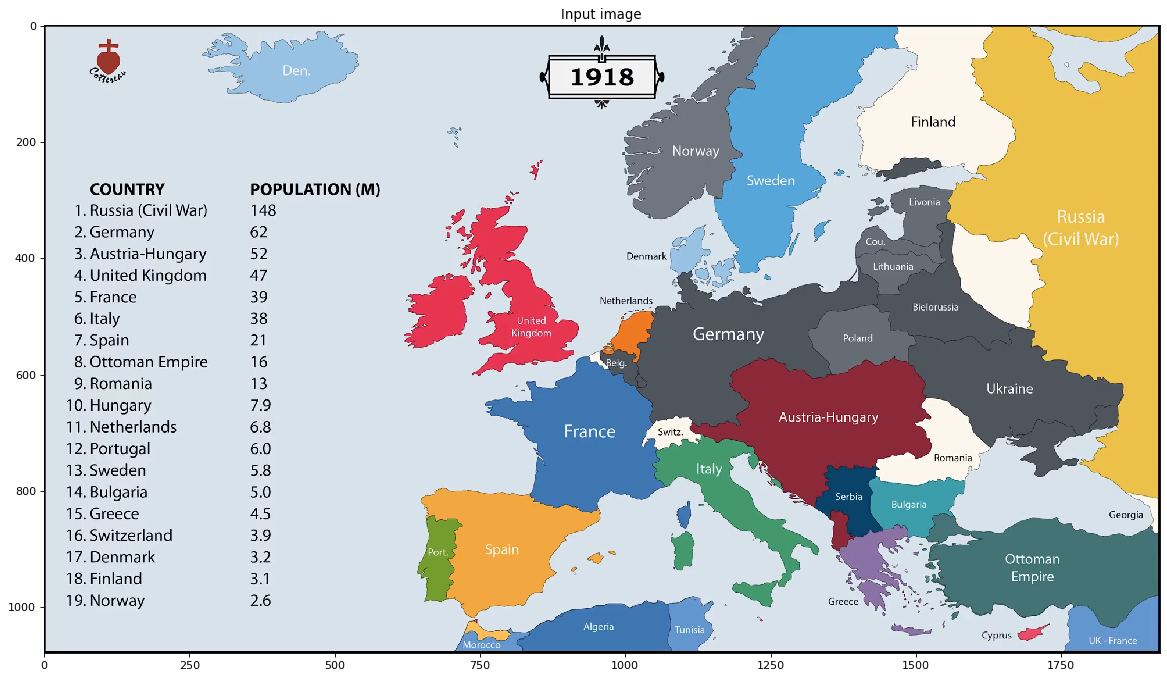

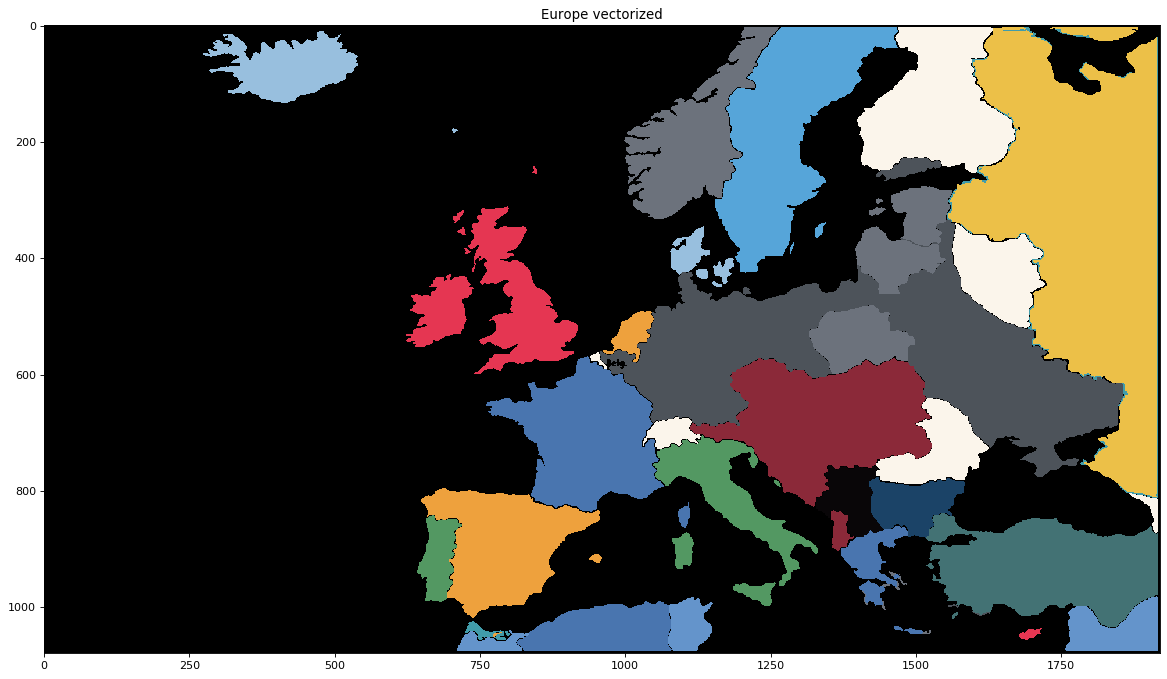

In [19]:
europe_filled_with_polygons = np.zeros(europe.shape)
for i, countryset in tqdm(enumerate(maps_countries), total=len(maps_countries)):
    europe_filled_with_polygons = draw_polygons(europe_filled_with_polygons, countryset, land_colors.iloc[i].color)

display_img(europe, 'Input image', True)
display_img(europe_filled_with_polygons, 'Europe vectorized', True)

In [20]:
plt.imsave('output/europe_vectorized.png', europe_filled_with_polygons)

In [21]:
import shapely.wkt
for i, color in enumerate(maps_countries):
    for j, country in enumerate(color) : 
        with open('tmp/'+str(i)+'_'+str(j)+'.wkt', 'w') as file:
            file.write(shapely.wkt.dumps(country))

In [ ]:
e